# Report results

In [351]:
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt

### Datasets characteristics

In [285]:
datasets = glob.glob('/Users/slawek/PycharmProjects/RecSysProject/data/*')

In [315]:
datasets_data = pd.DataFrame()
for dataset in datasets:
    name = dataset.rsplit('/', 1)[-1]
    df_path = os.path.join(dataset, 'processed', 'interactions.csv')
    df = pd.read_csv(df_path)
    num_users = df['user_id'].nunique()
    num_items = df['item_id'].nunique()
    num_baskets = sum(df.groupby('user_id')['basket_id'].nunique())
    avg_basket_size = df.groupby(['user_id','basket_id'])['item_id'].nunique().reset_index().item_id.mean()
    num_baskets_per_user = df.groupby('user_id')['basket_id'].nunique().mean()
    min_basket_size = df.groupby(['user_id','basket_id'])['item_id'].nunique().reset_index().item_id.min()
    max_basket_size = df.groupby(['user_id','basket_id'])['item_id'].nunique().reset_index().item_id.max()
    datasets_data = datasets_data._append({'Dataset': name, '#Users': num_users, '#Items': num_items, '#Baskets': num_baskets, 'Avg. basket size': avg_basket_size, '#Baskets per user': num_baskets_per_user, 'Min. basket size': min_basket_size, 'Max. basket size': max_basket_size}, ignore_index=True)

In [317]:
datasets_data.to_csv('/Users/slawek/PycharmProjects/RecSysProject/report_results/datasets_data.csv', index=False)

### Fairness

#### Metrics vs. average basket size

In [413]:
datasets = ['tafeng', 'instacart', 'dunnhumby', 'valuedshopper']

tafeng
           recall@010  user_id
bin                           
(0, 5]       0.164808     7999
(5, 10]      0.093196     3364
(10, 15]     0.091896     1308
(15, 20]     0.106612      605
(20, 25]     0.148173      301
(25, 30]     0.136601      153
(30, 35]     0.156338       71
(35, 40]     0.202778       36
(40, 45]     0.210345       29
(45, 50]     0.425000        8
(50, 55]     0.228571        7
(55, 60]     0.300000        3
(60, 65]     0.333333        3
(65, 70]          NaN        0
(70, 75]     0.300000        1
(75, 80]          NaN        0
(80, 85]          NaN        0
(85, 90]          NaN        0
(90, 95]     0.200000        1
(95, 100]         NaN        0
           recall@020  user_id
bin                           
(0, 5]       0.232639     7999
(5, 10]      0.135919     3364
(10, 15]     0.110591     1308
(15, 20]     0.093566      605
(20, 25]     0.112625      301
(25, 30]     0.112418      153
(30, 35]     0.122535       71
(35, 40]     0.152778       36
(

/var/folders/nf/nlqft1994556cpj2_qmx79sm0000gp/T/ipykernel_15808/2994512377.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax1 = plt.subplots(figsize=(15, 10))


           precision@020  user_id
bin                              
(0, 5]          0.085252     7296
(5, 10]         0.183350     6135
(10, 15]        0.272626     3286
(15, 20]        0.344936     1708
(20, 25]        0.417112      786
(25, 30]        0.470676      370
(30, 35]        0.518944      161
(35, 40]        0.556818       66
(40, 45]        0.559615       26
(45, 50]        0.582143       14
(50, 55]        0.642857        7
(55, 60]        0.450000        1
(60, 65]        0.900000        1
(65, 70]        0.800000        1
(70, 75]             NaN        0
(75, 80]             NaN        0
(80, 85]             NaN        0
(85, 90]             NaN        0
(90, 95]             NaN        0
(95, 100]            NaN        0
             f1@010  user_id
bin                         
(0, 5]     0.212172     7296
(5, 10]    0.304343     6135
(10, 15]   0.373585     3286
(15, 20]   0.450761     1708
(20, 25]   0.522010      786
(25, 30]   0.566757      370
(30, 35]   0.603727 

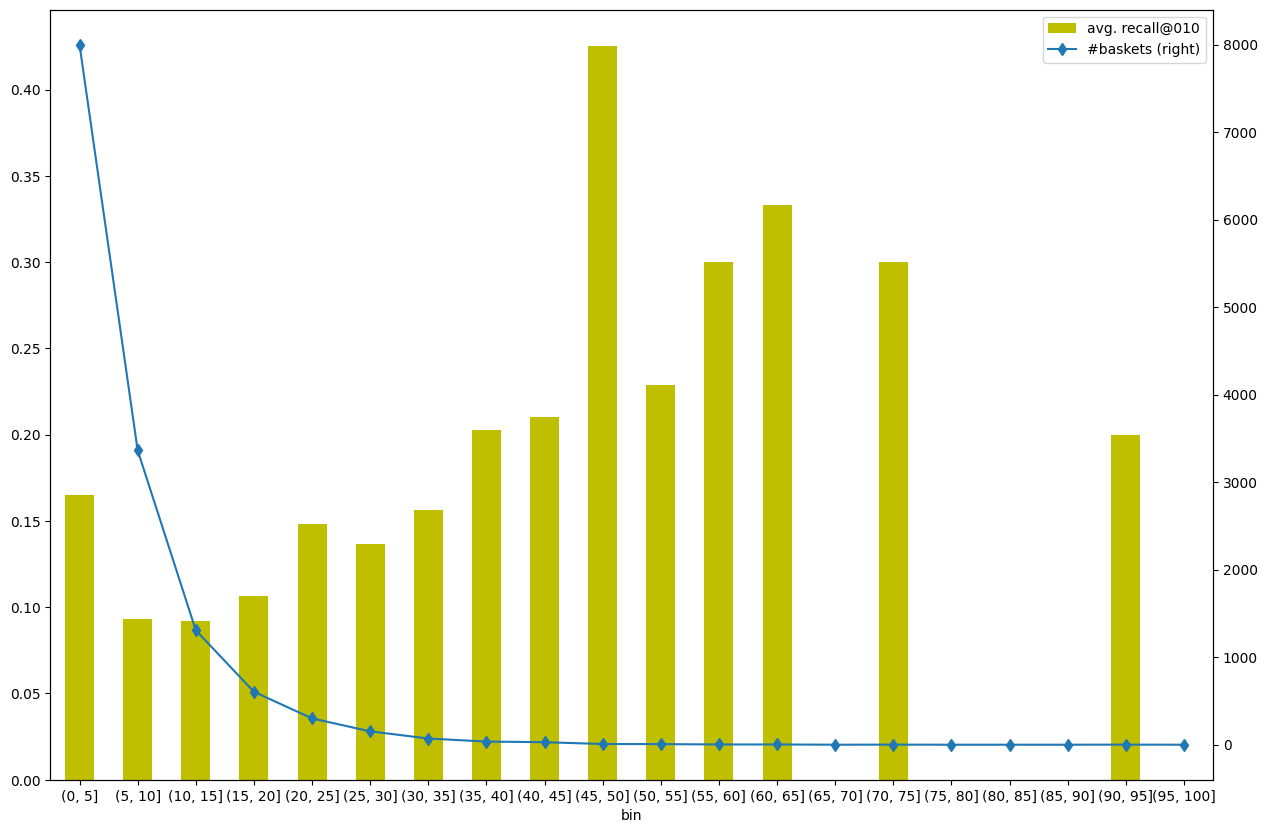

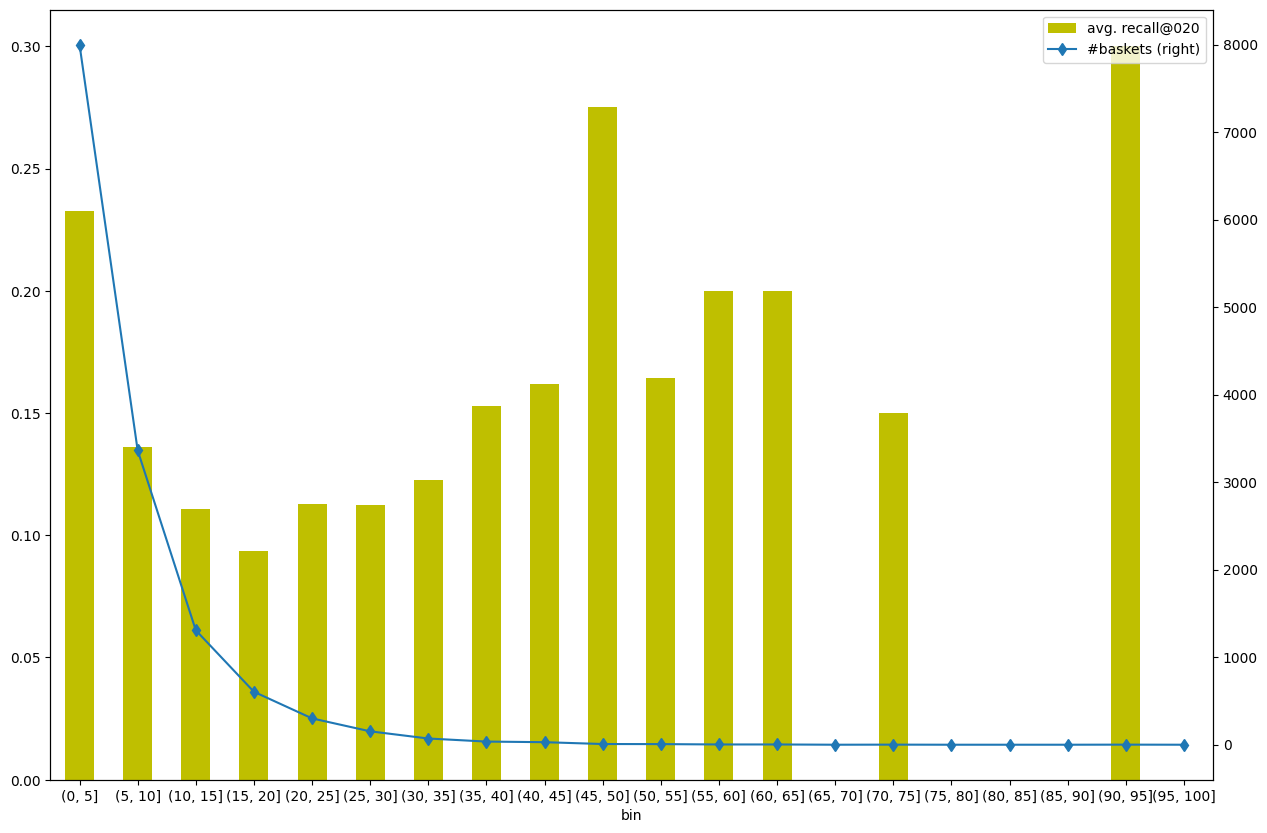

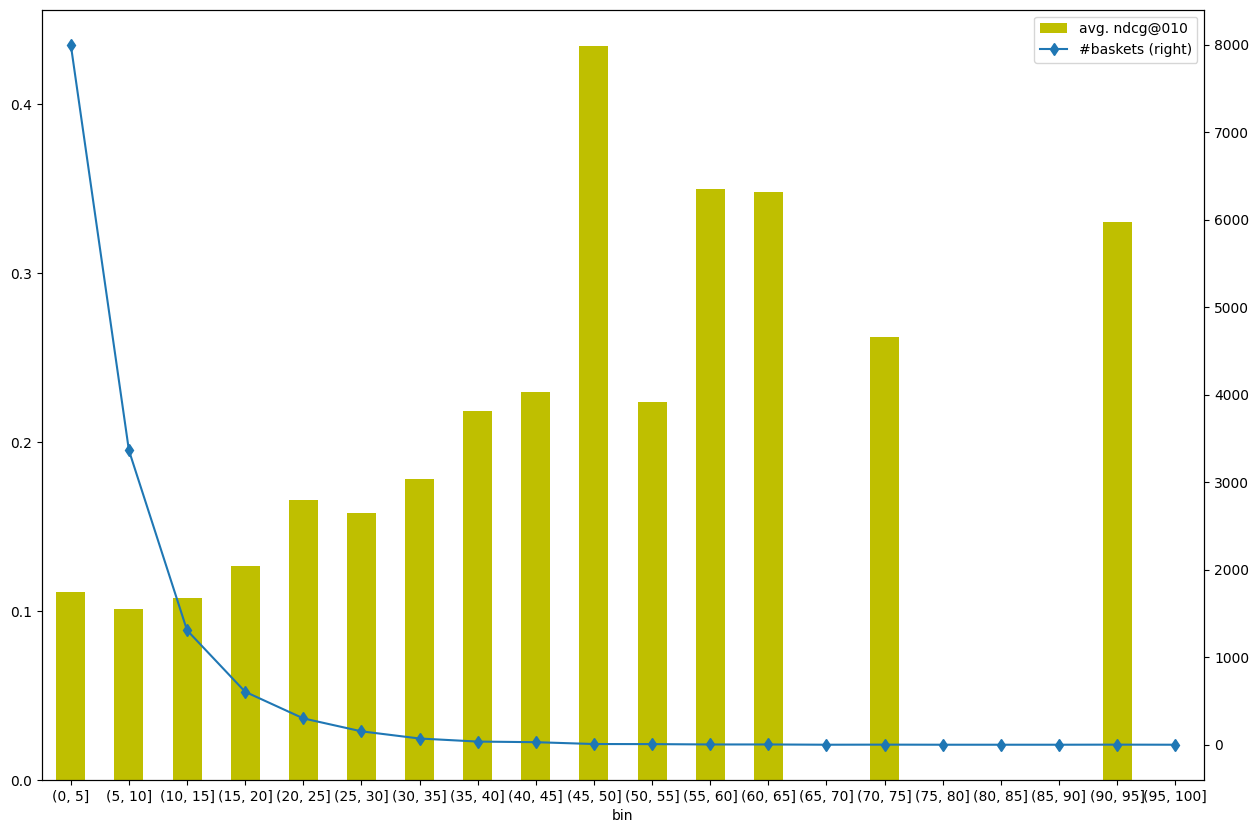

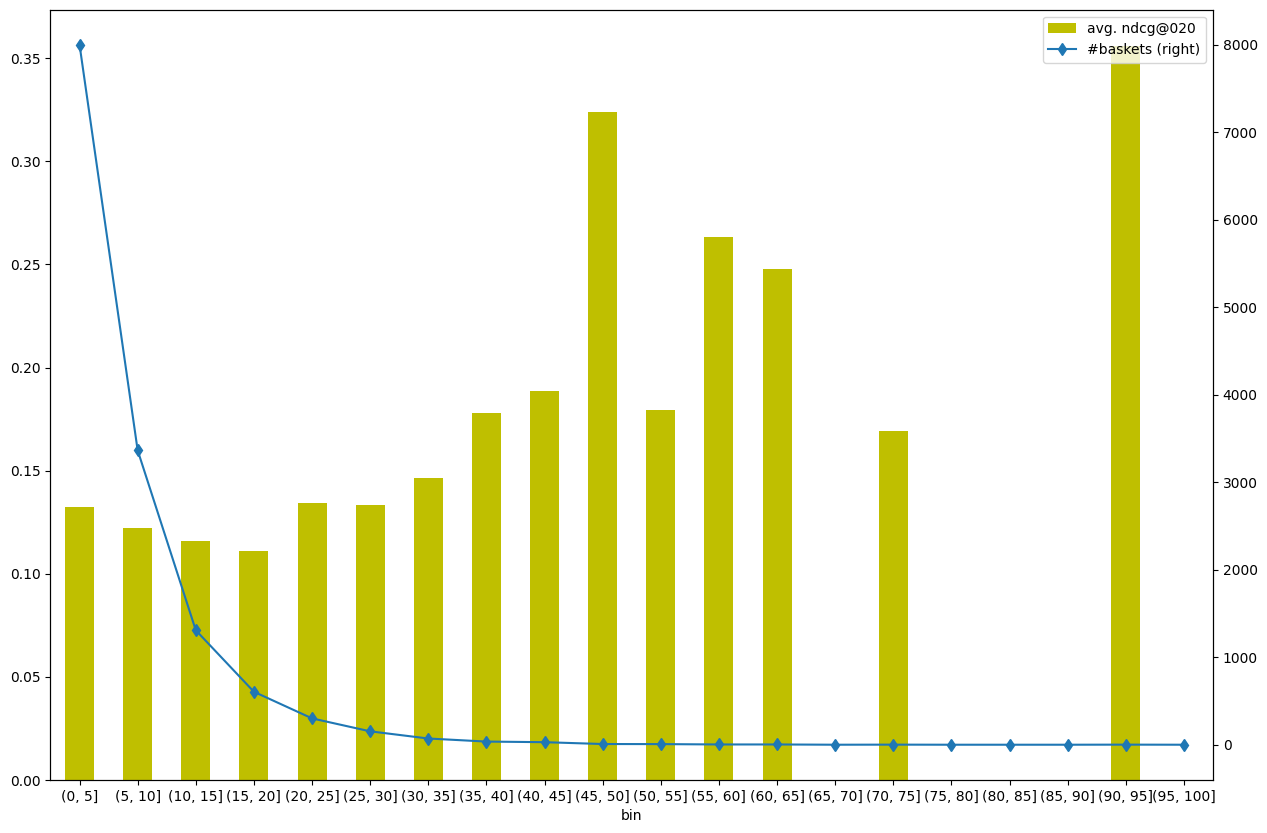

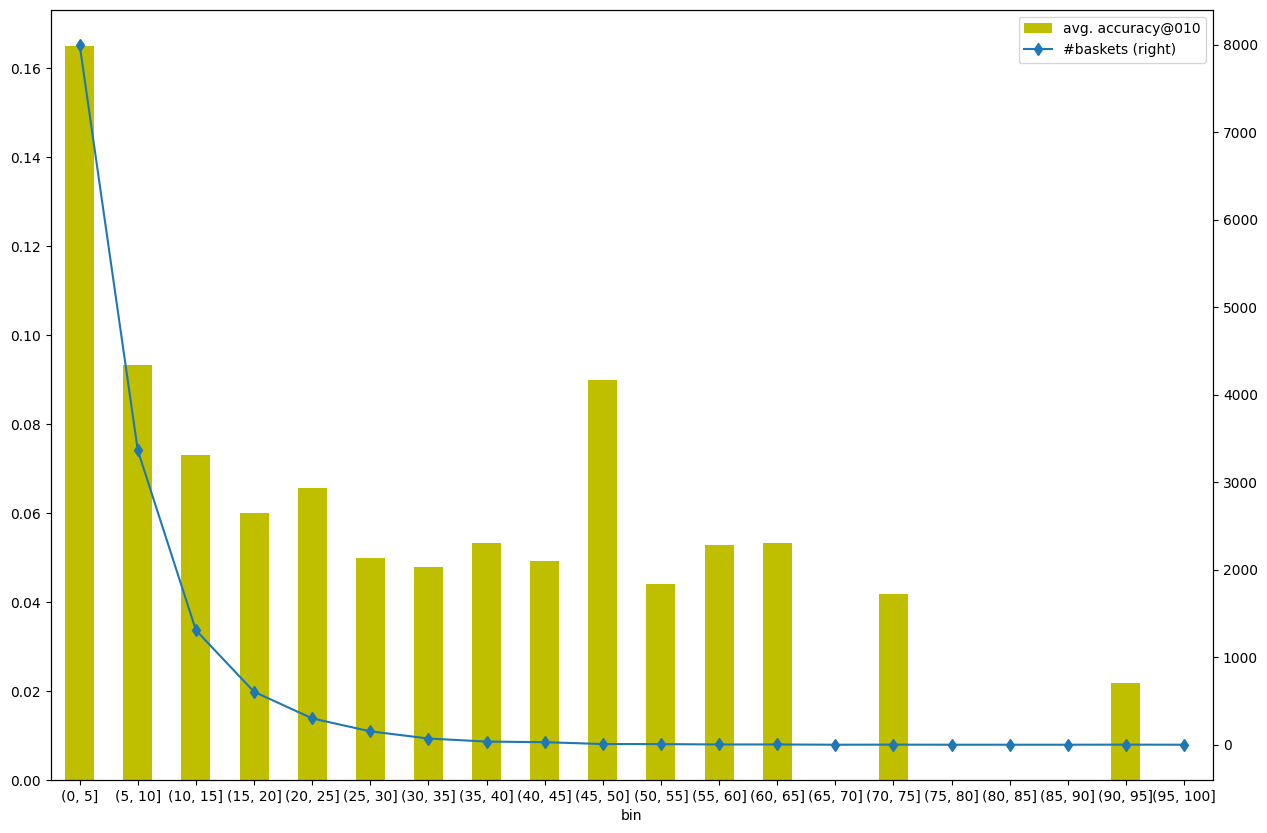

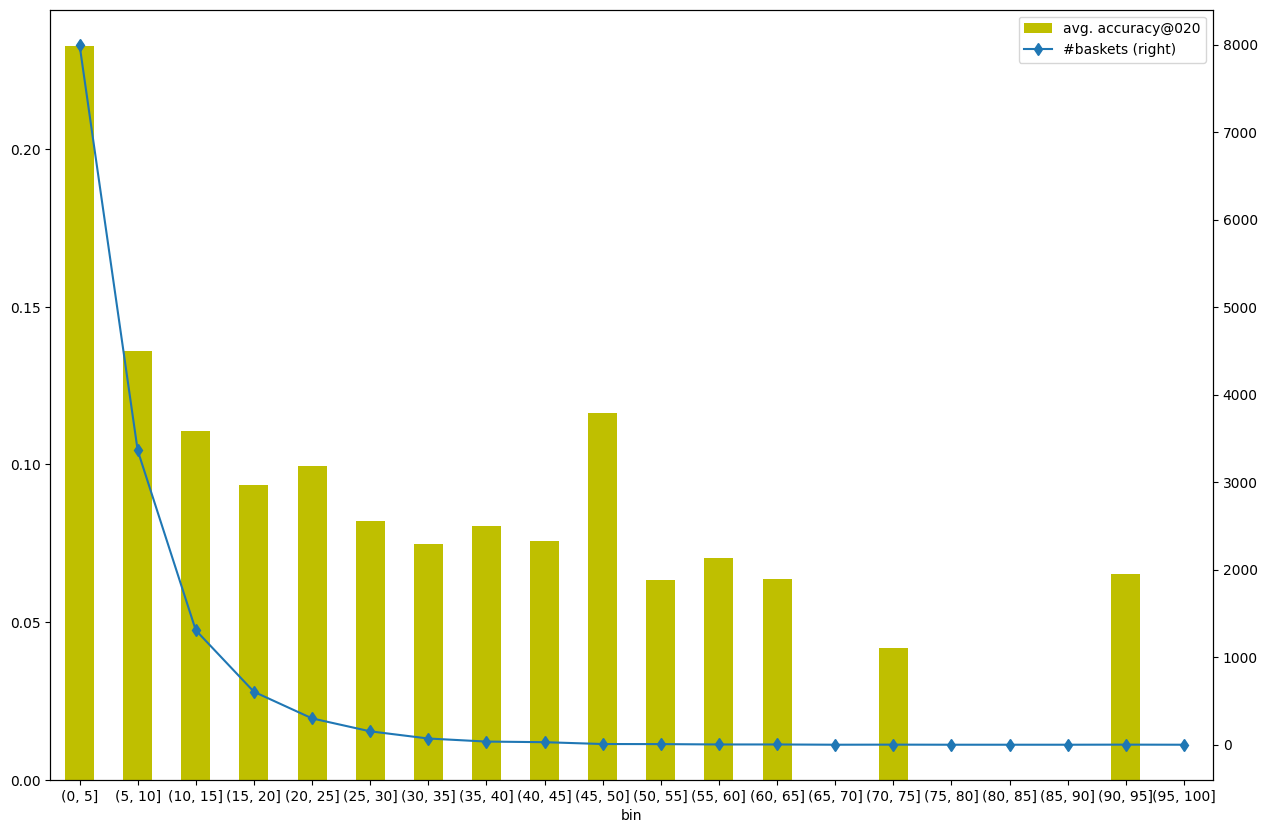

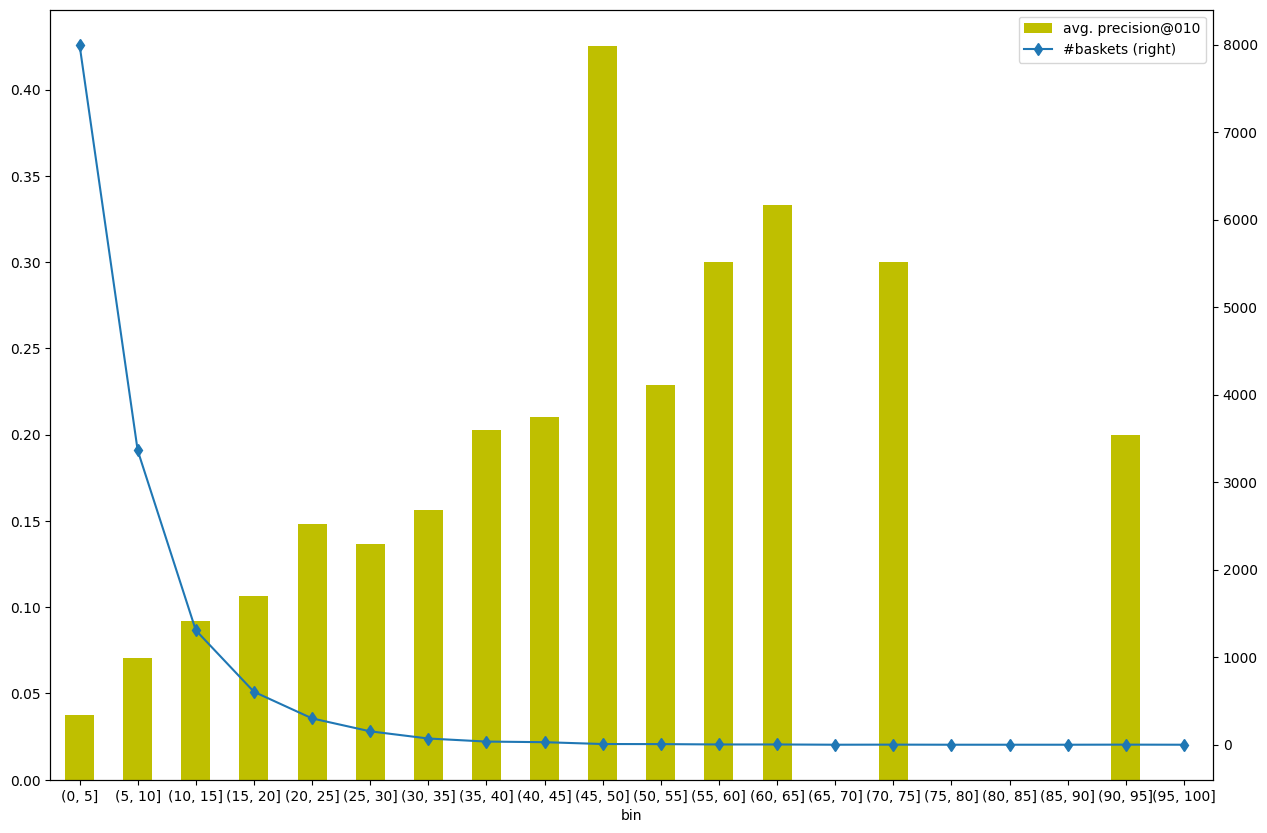

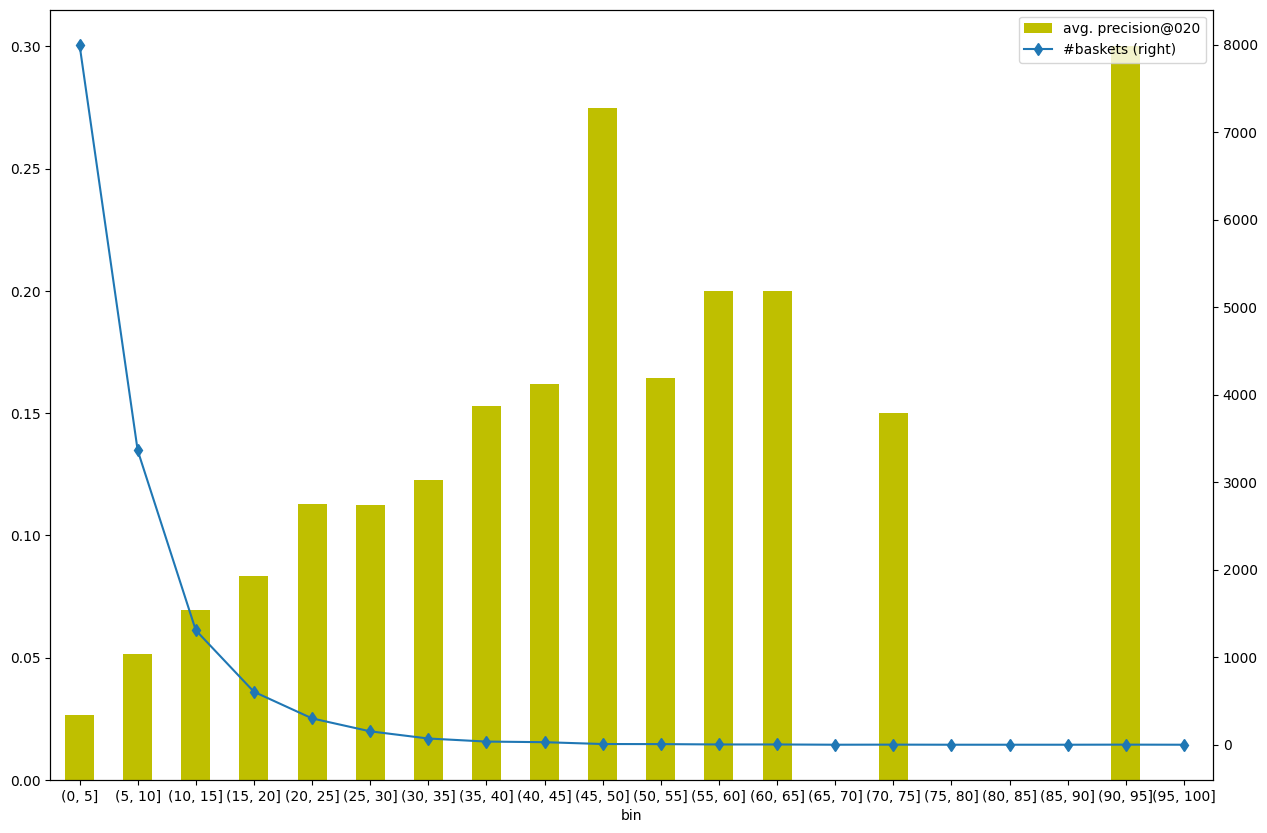

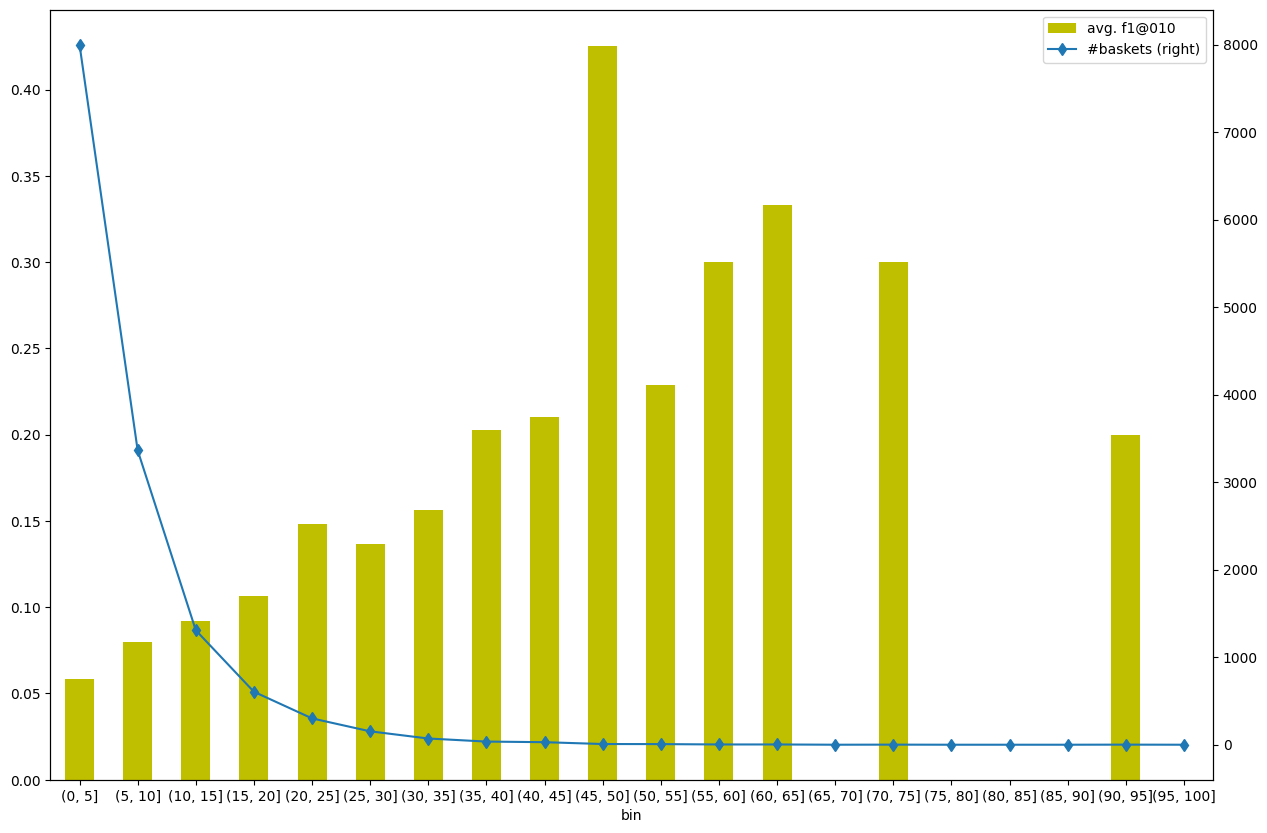

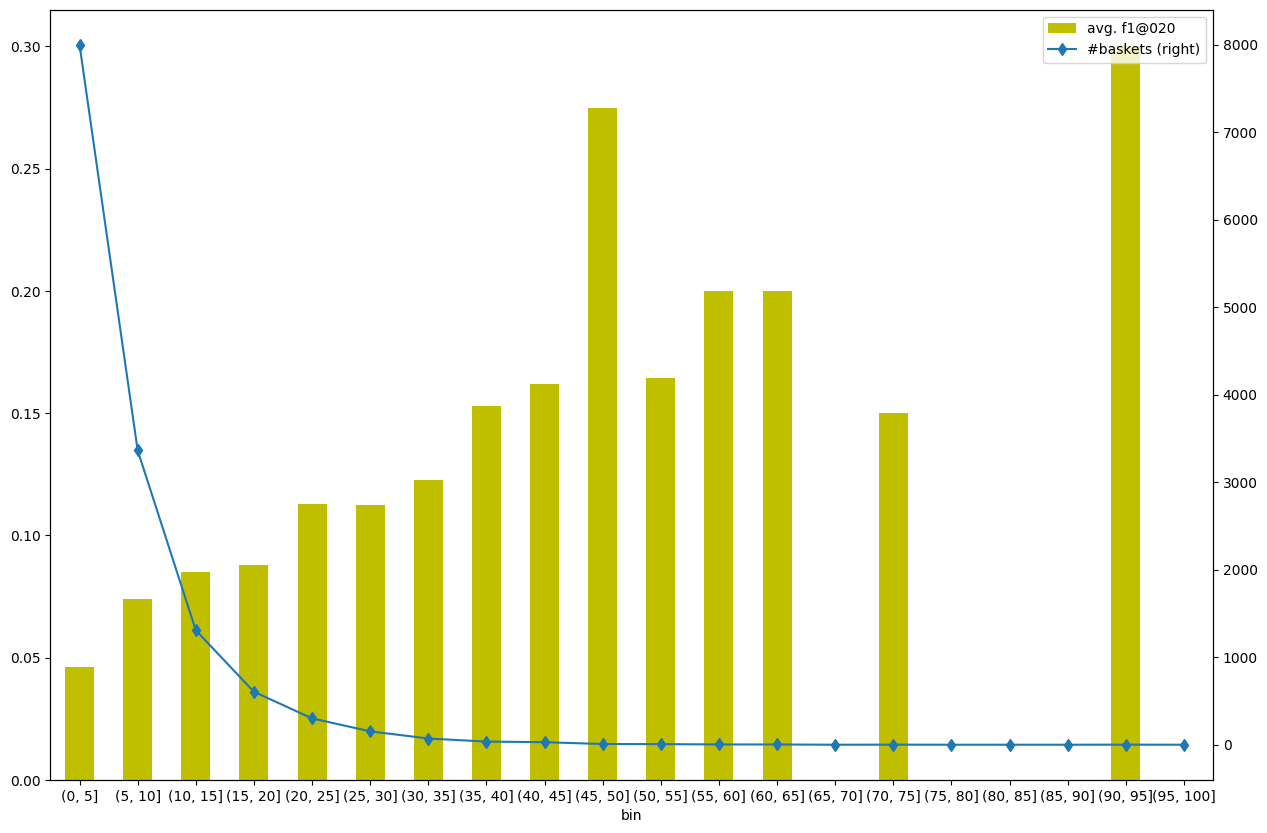

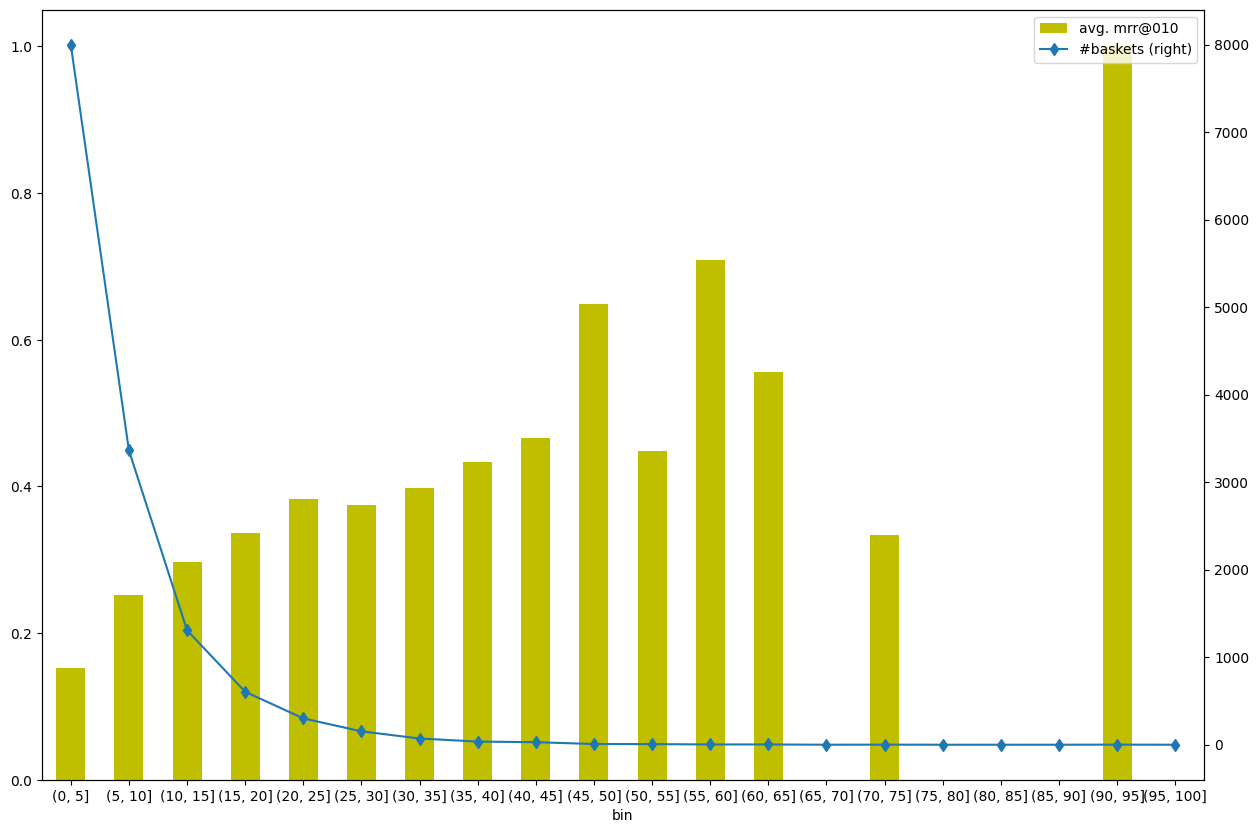

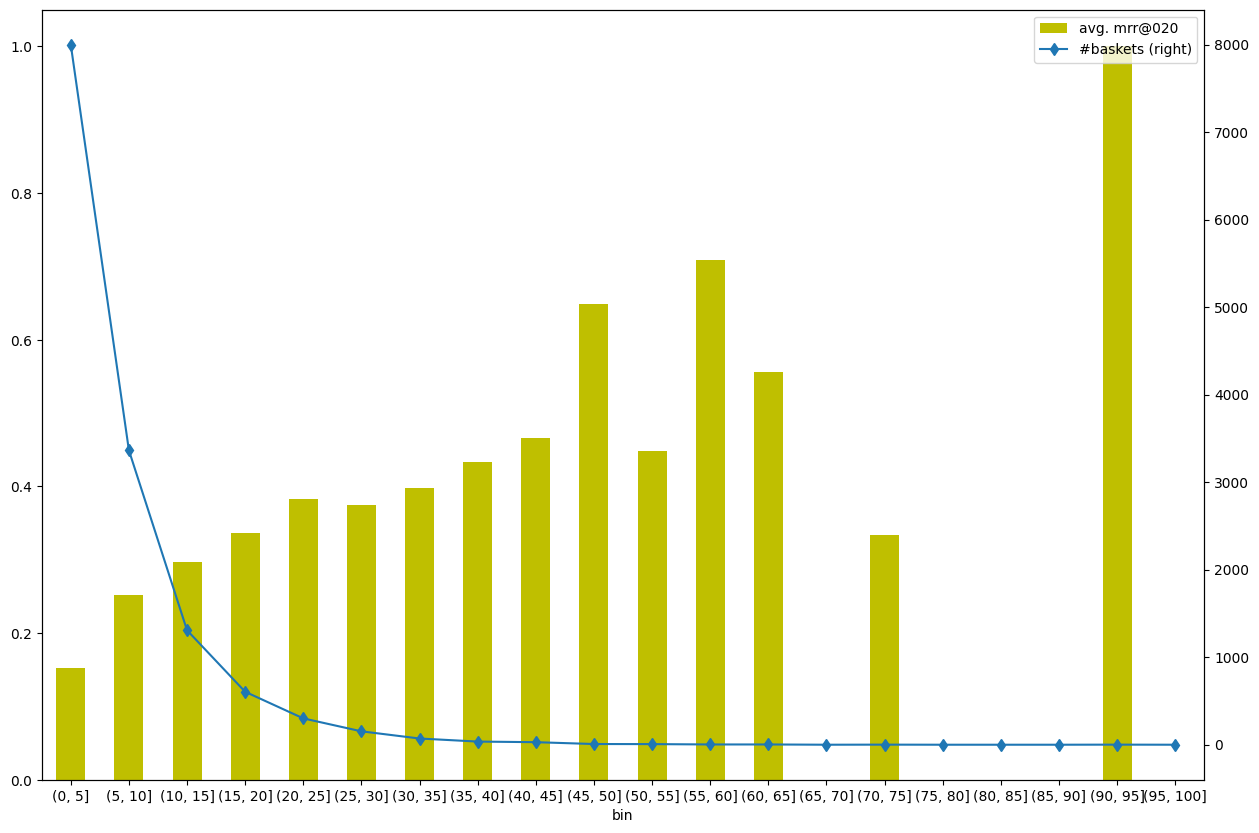

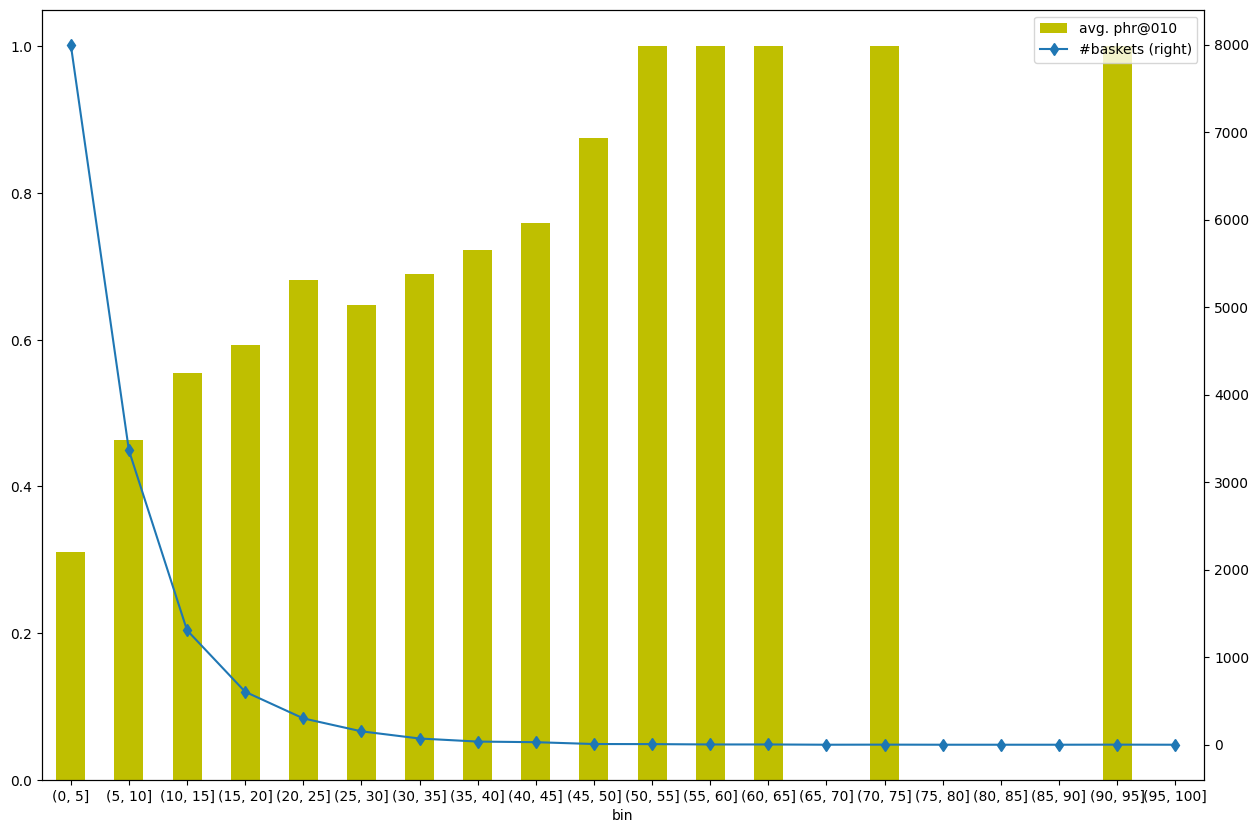

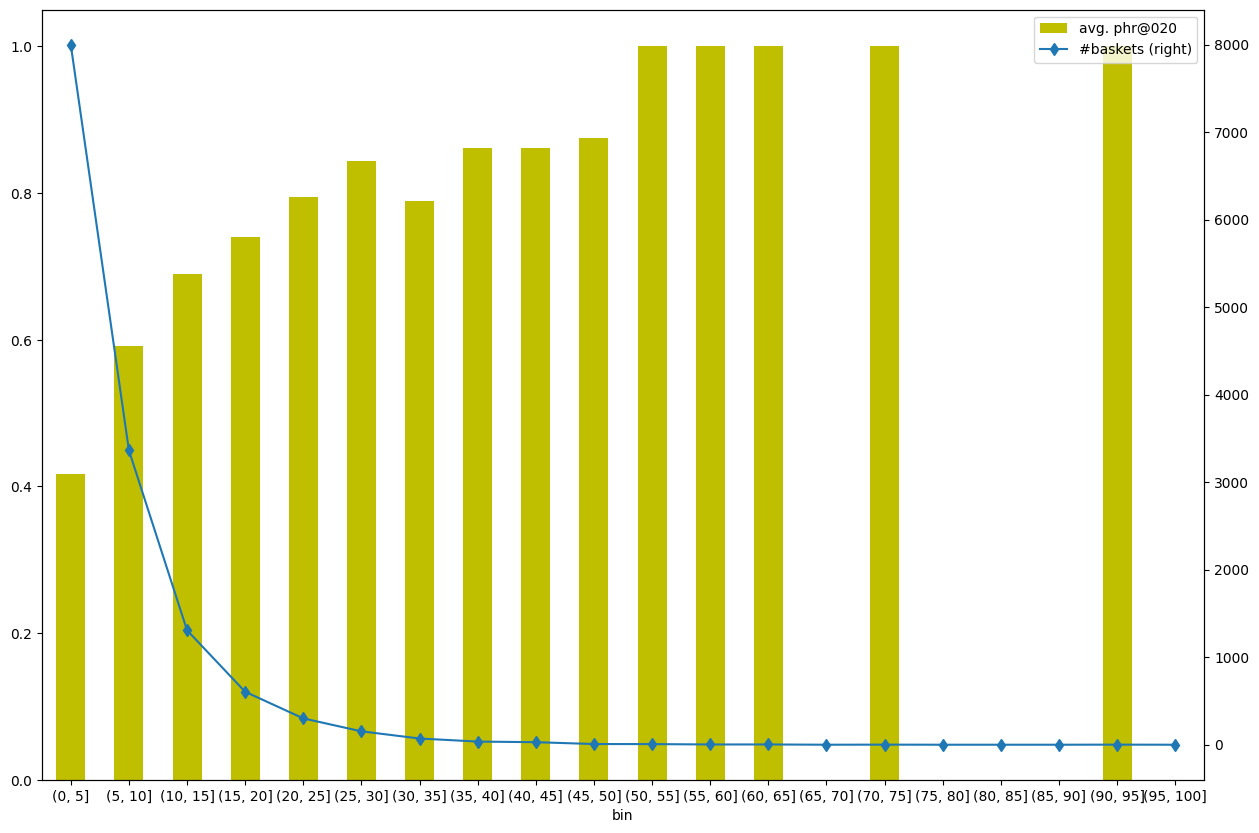

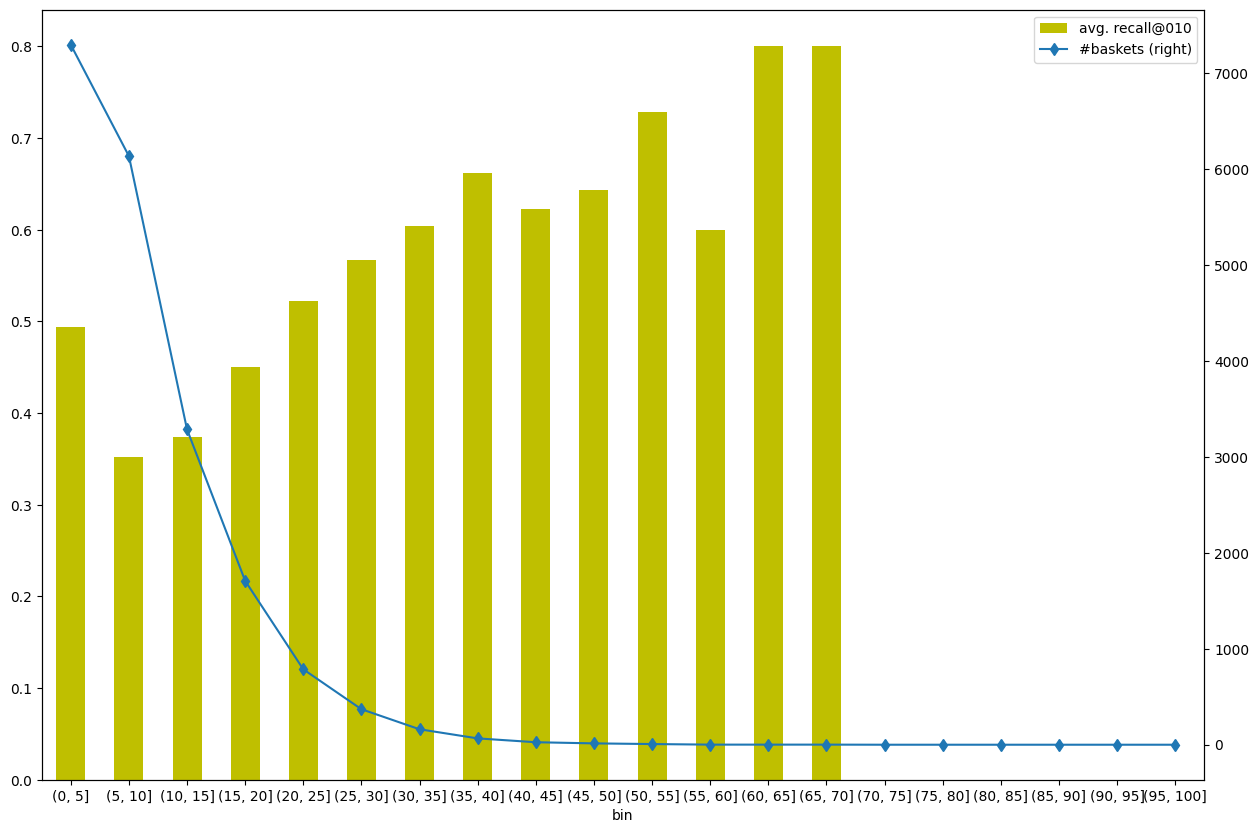

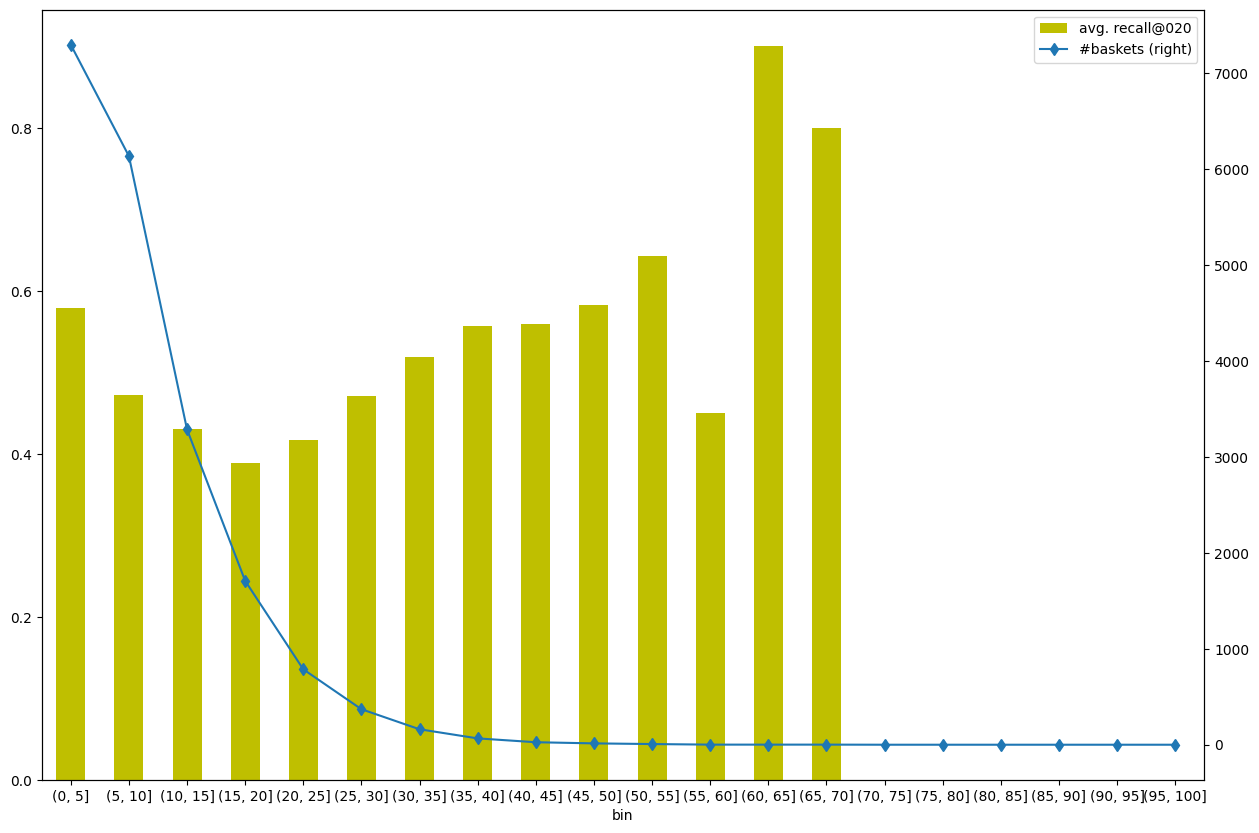

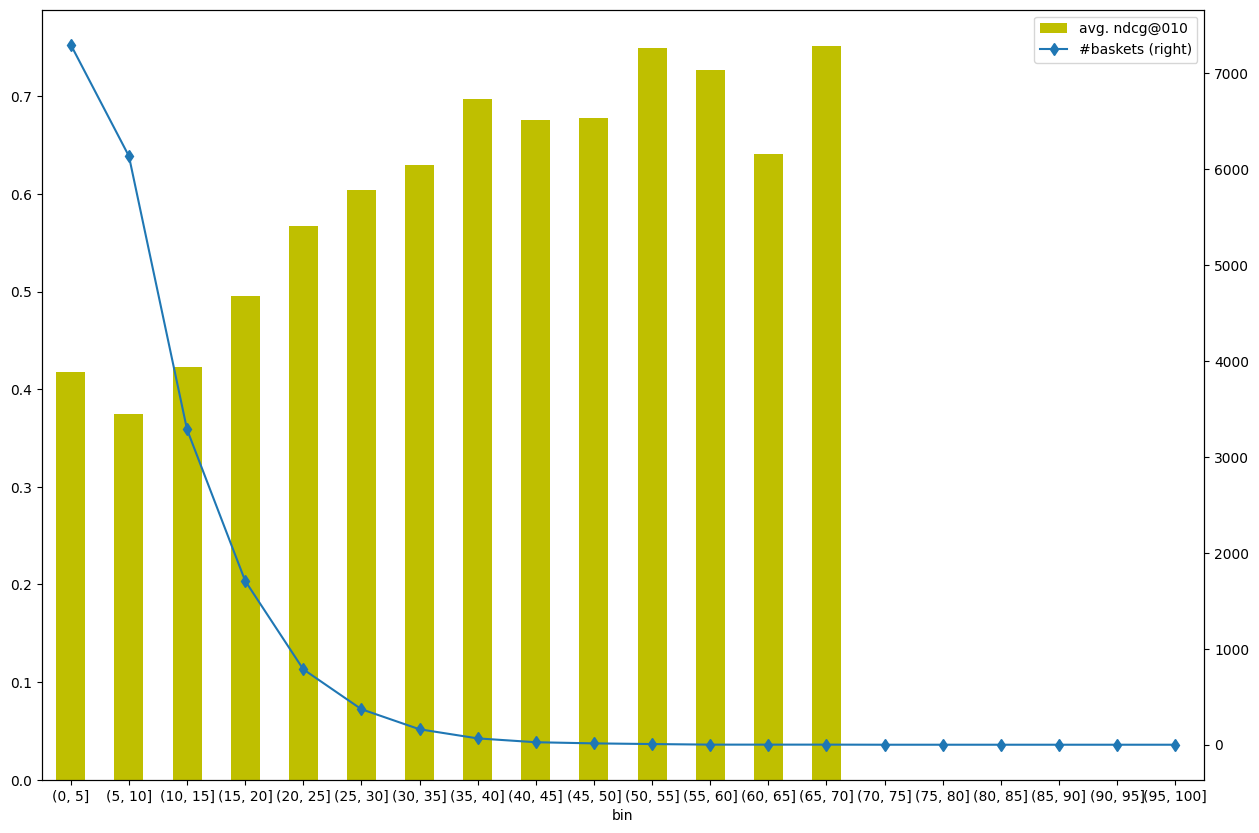

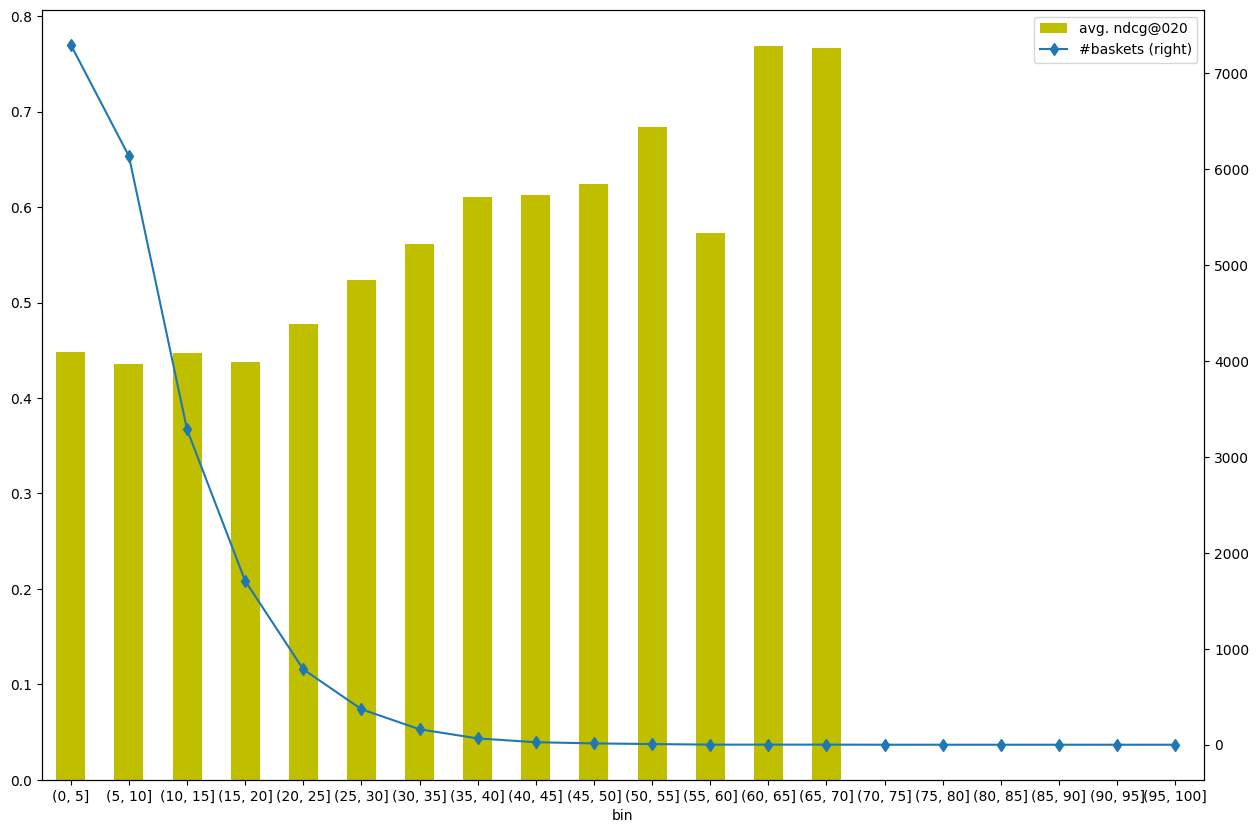

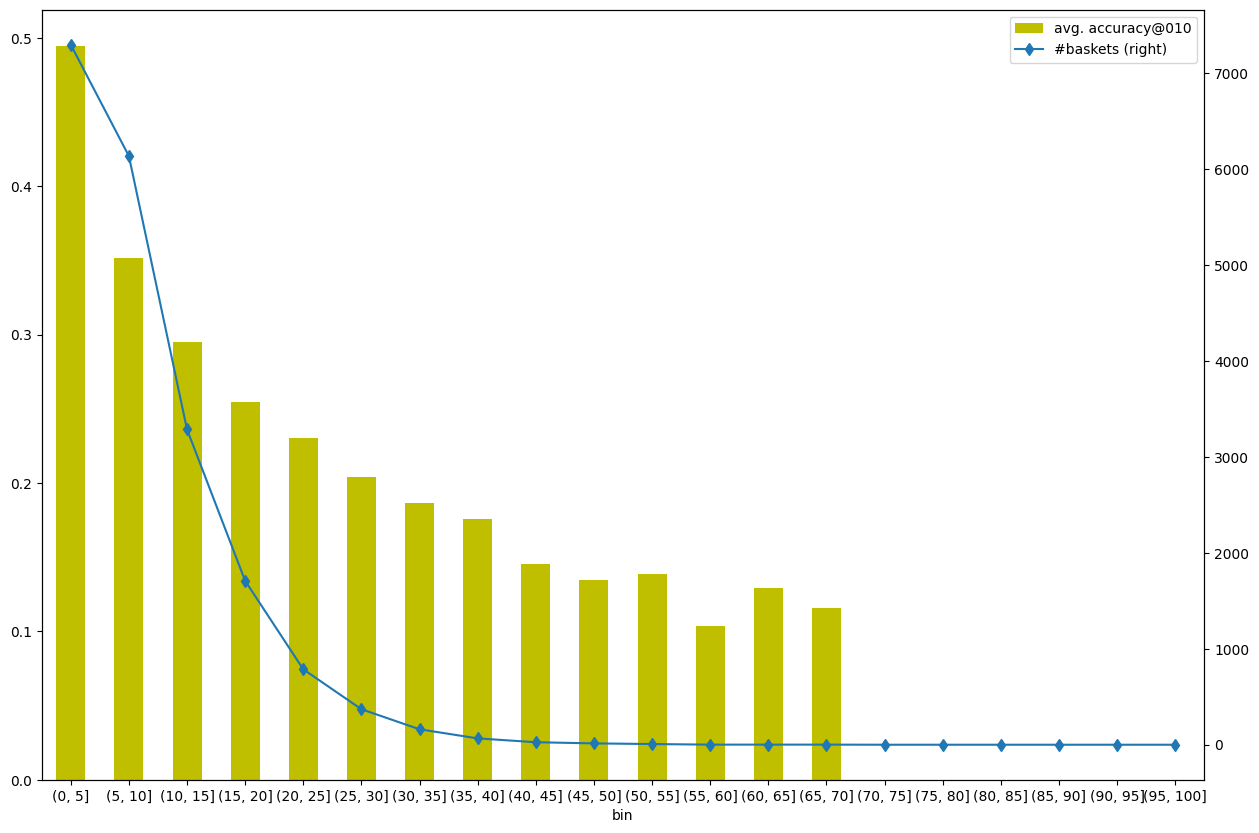

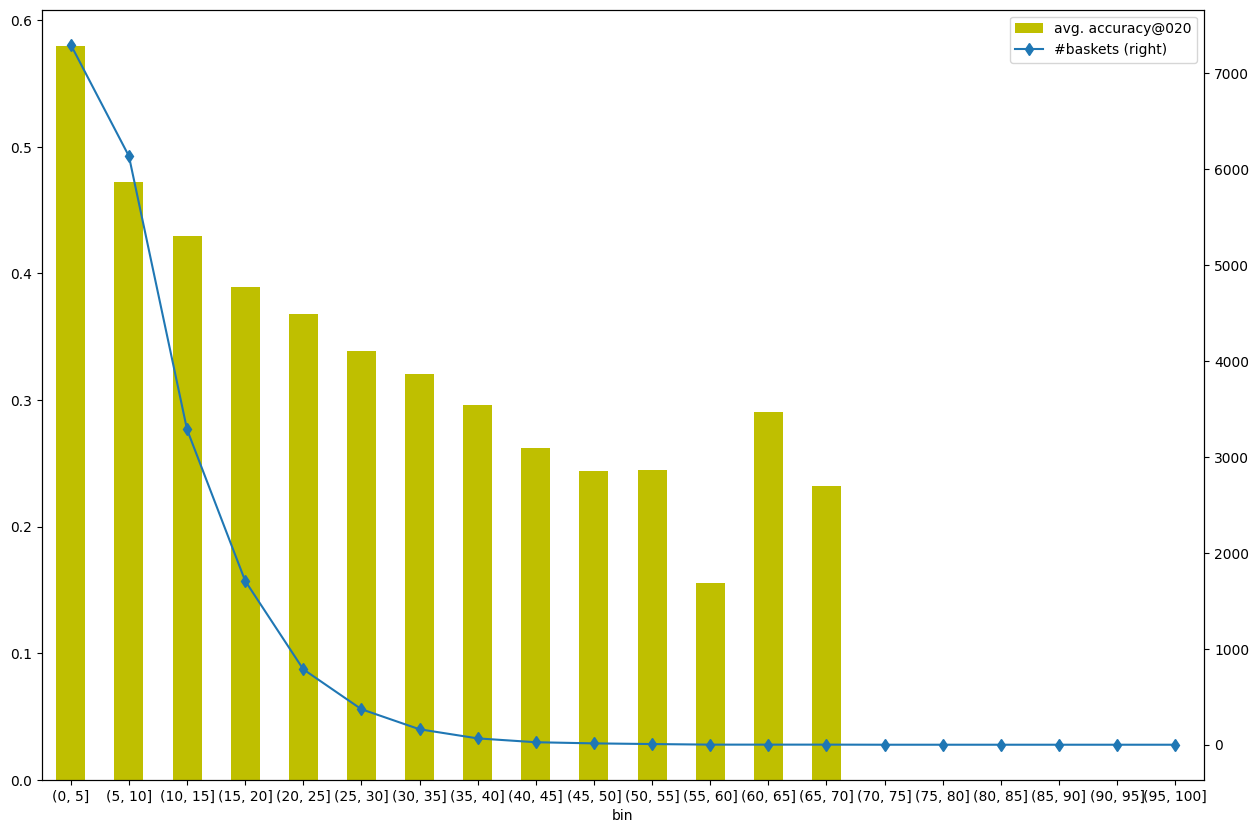

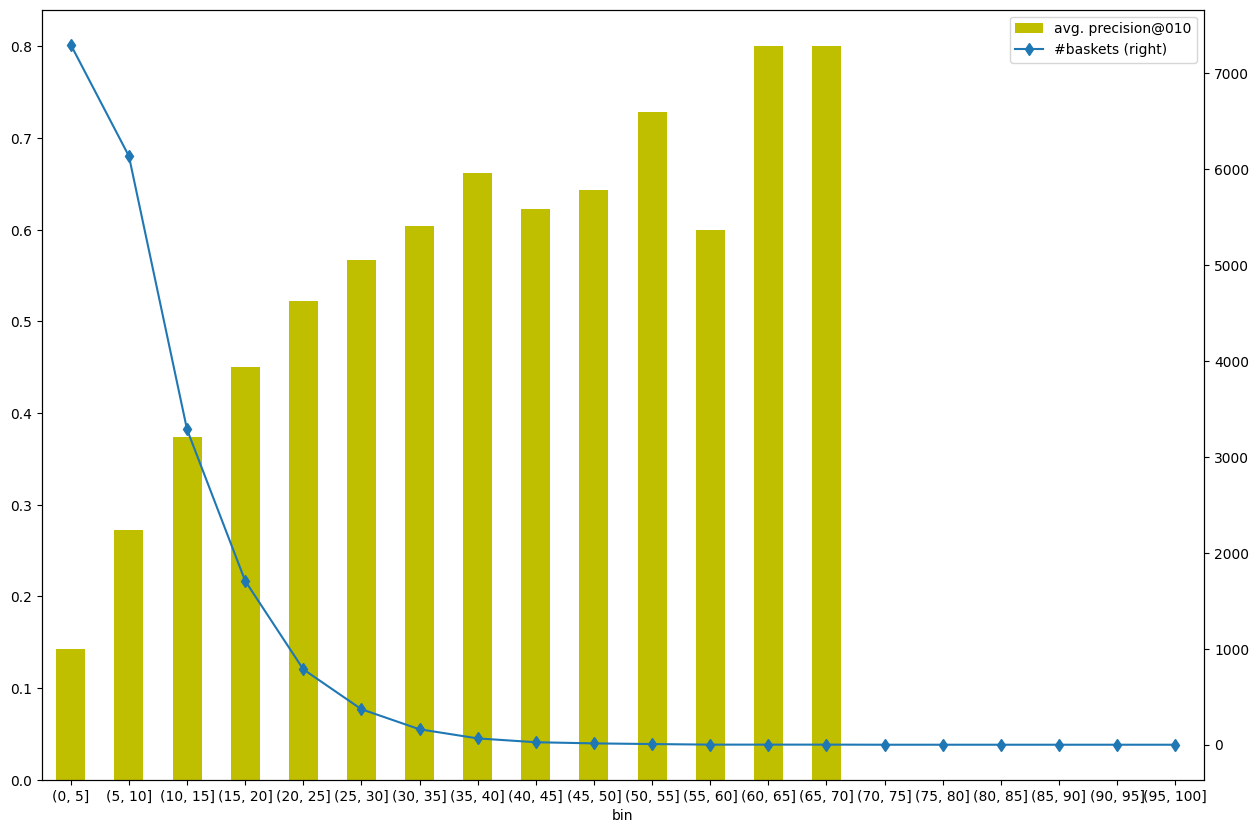

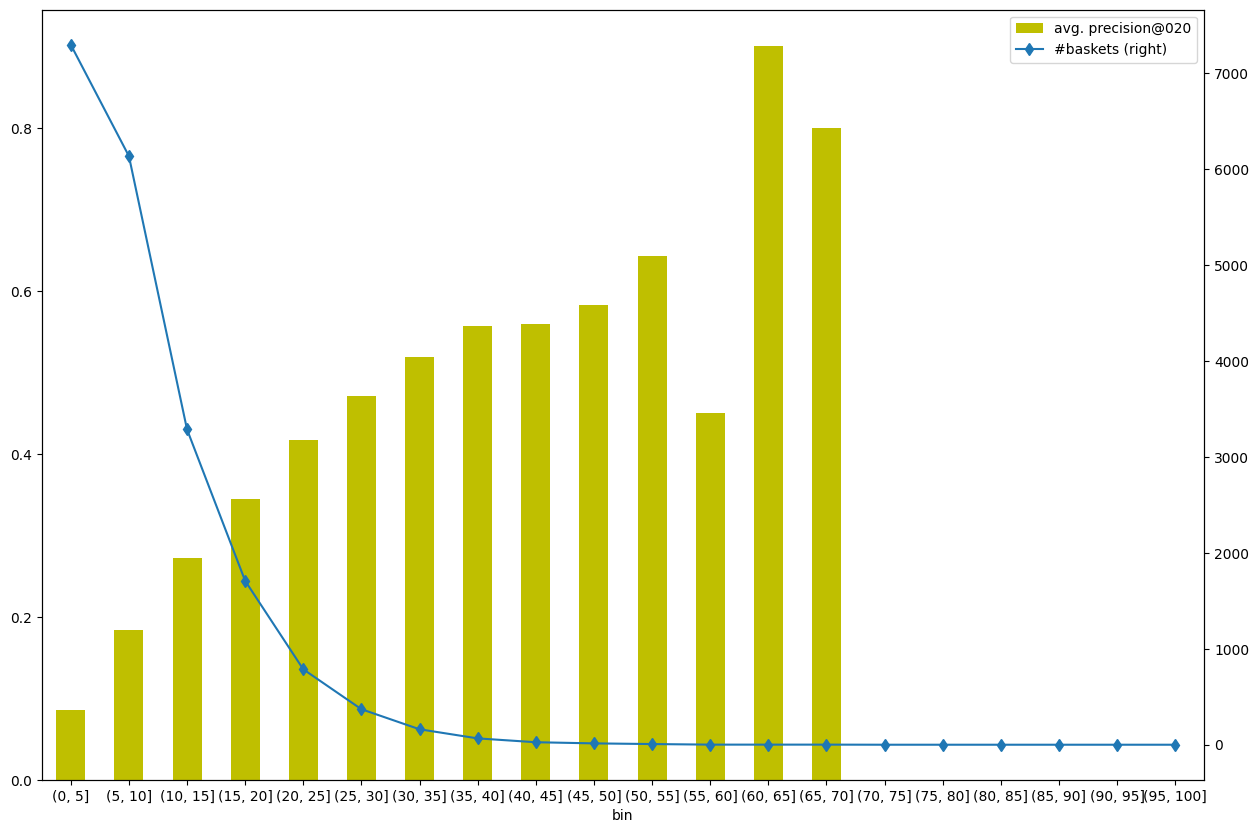

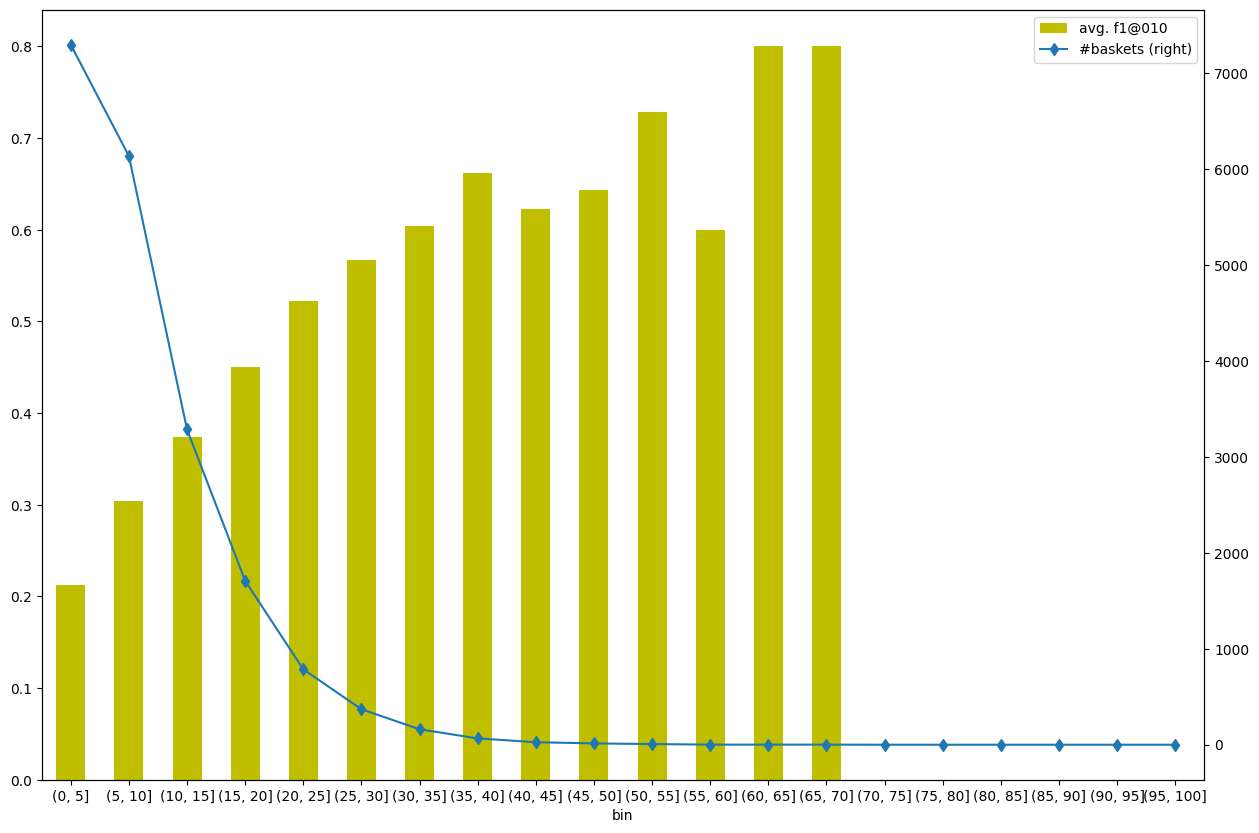

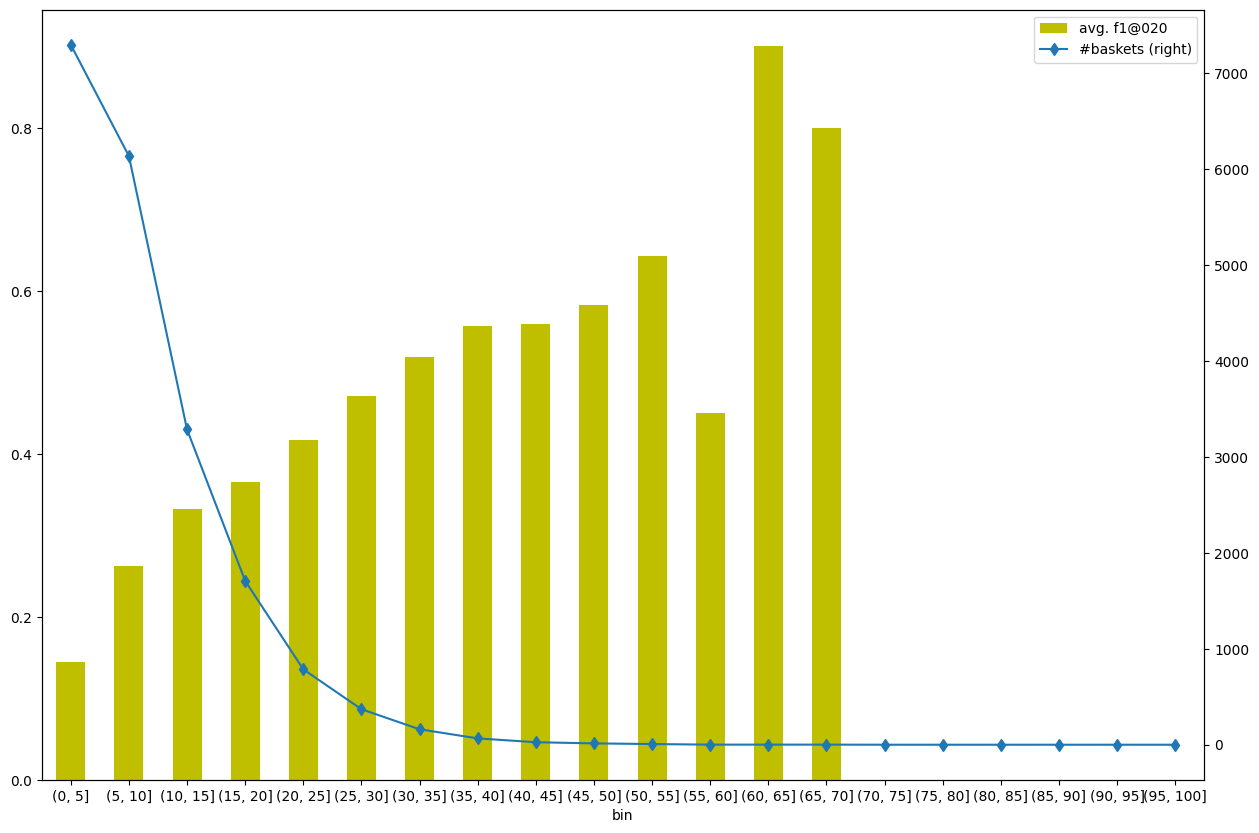

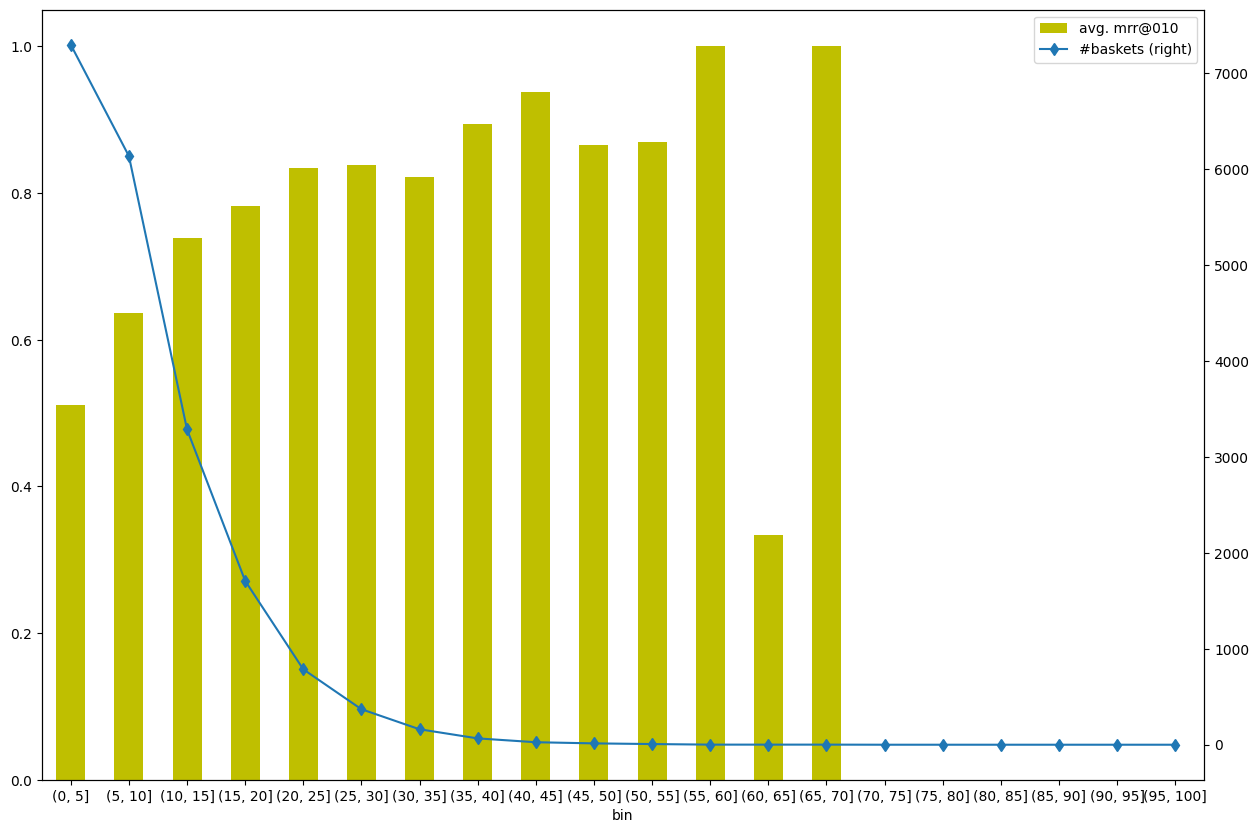

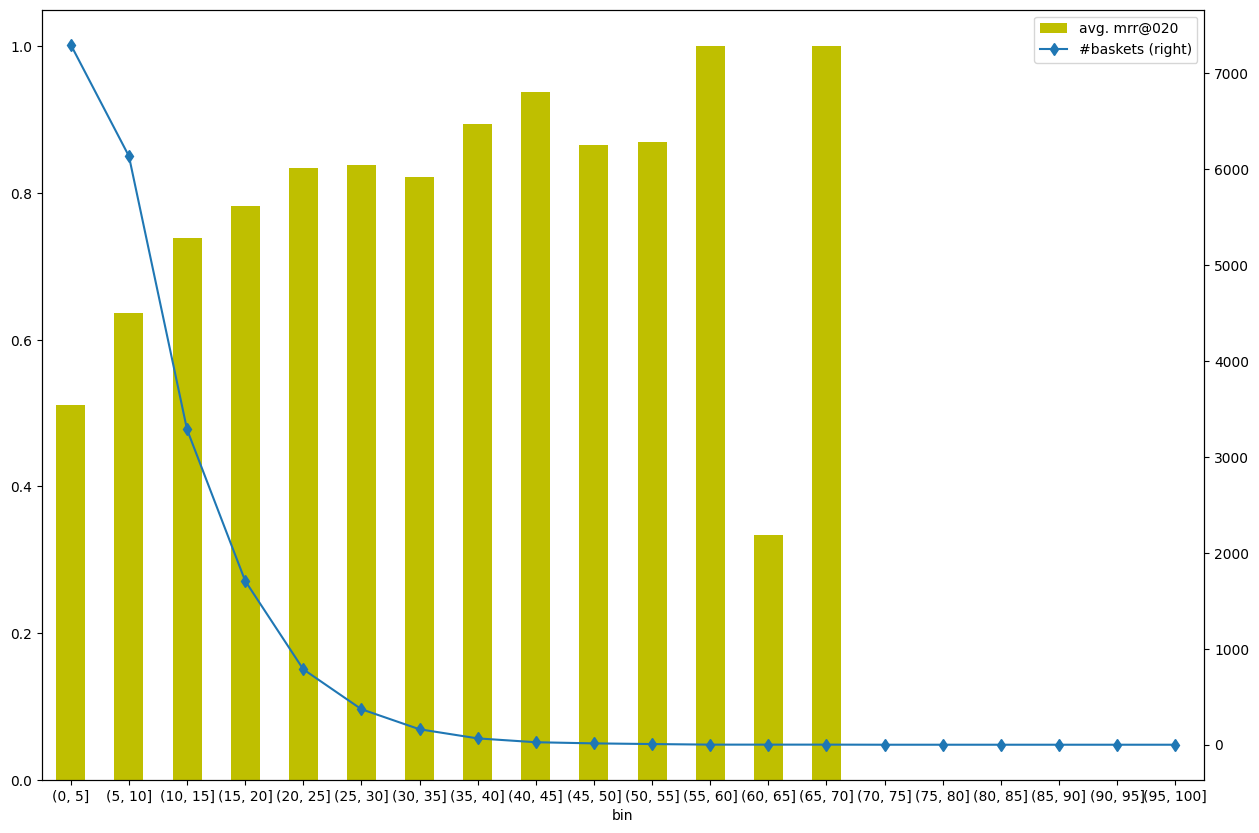

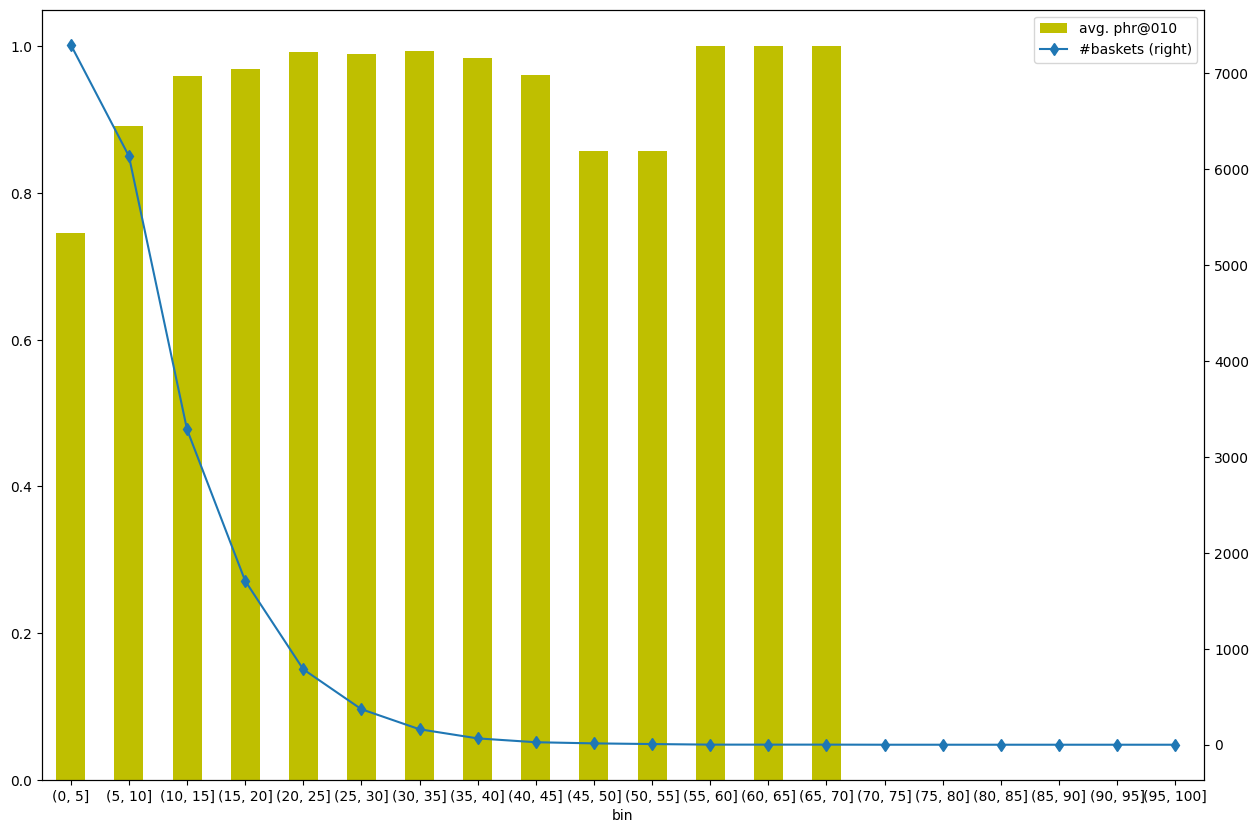

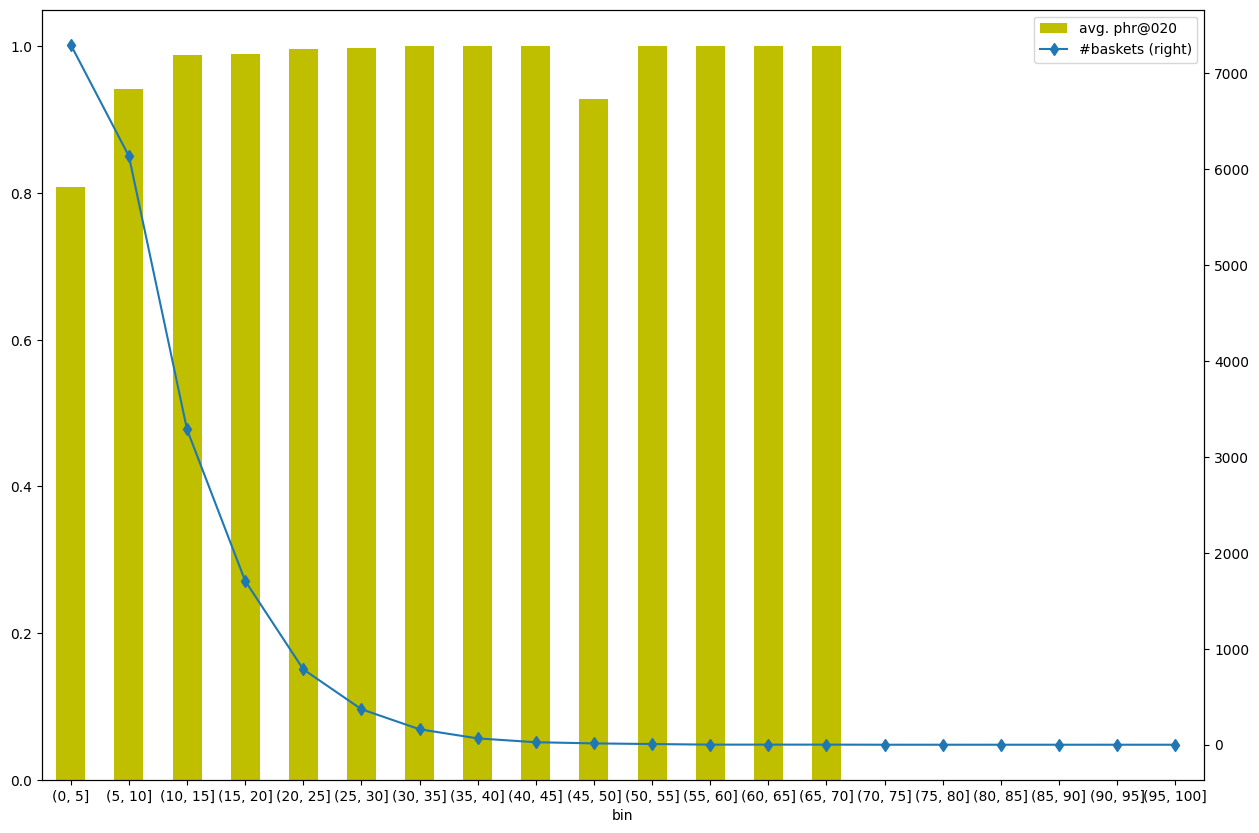

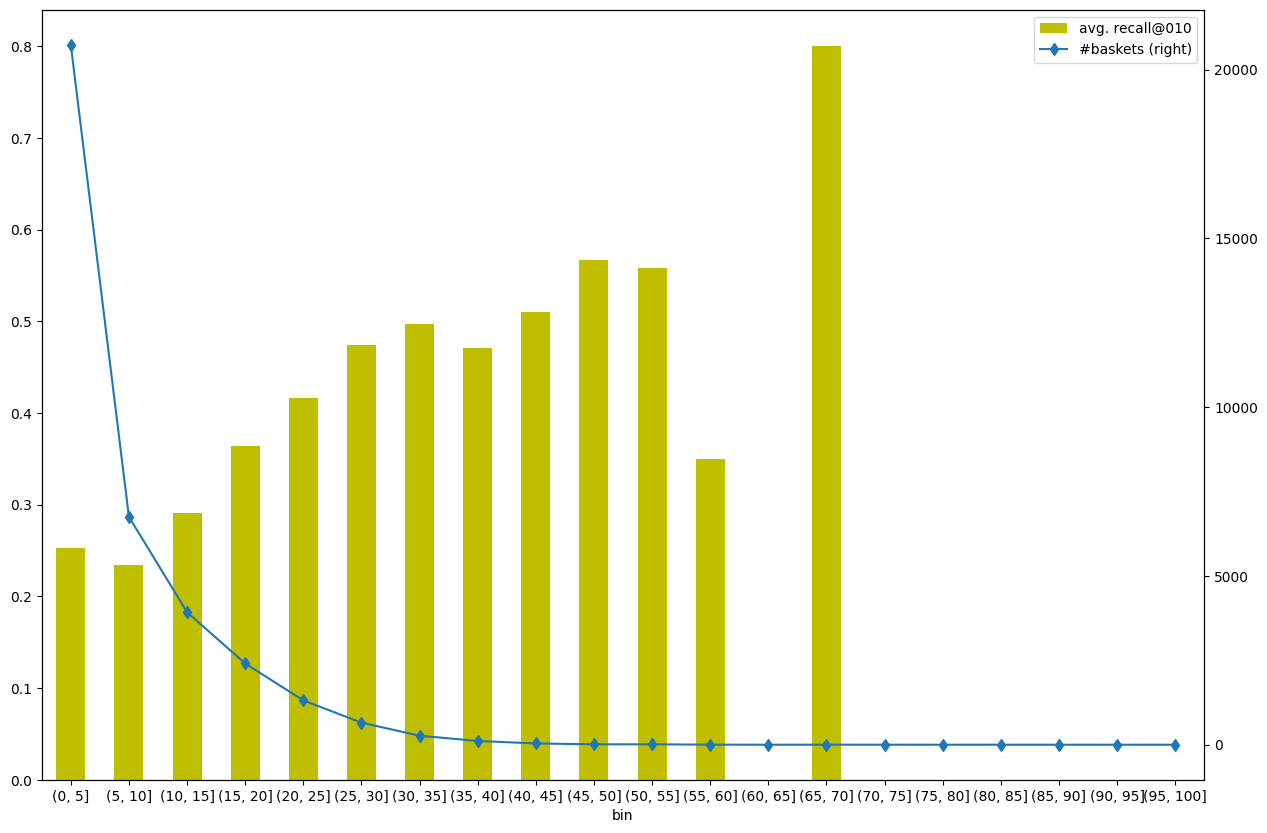

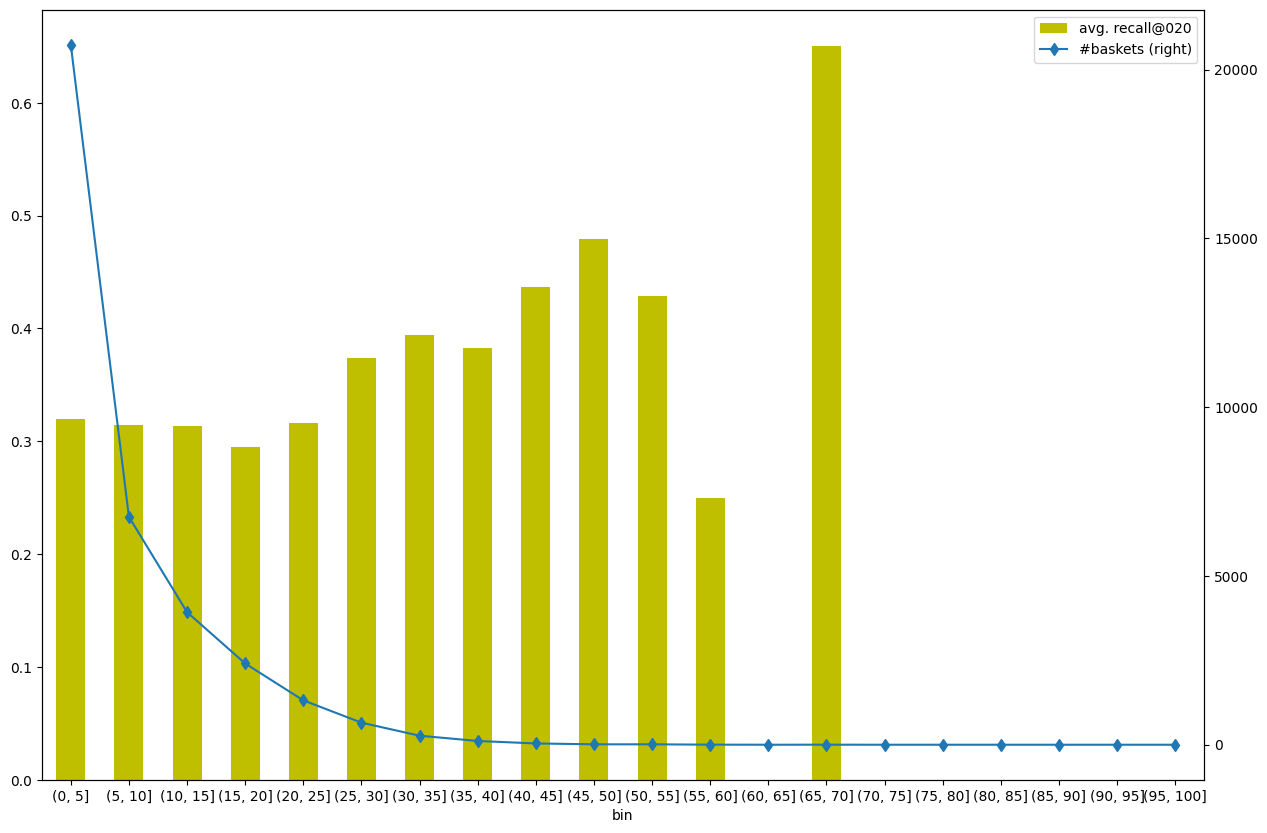

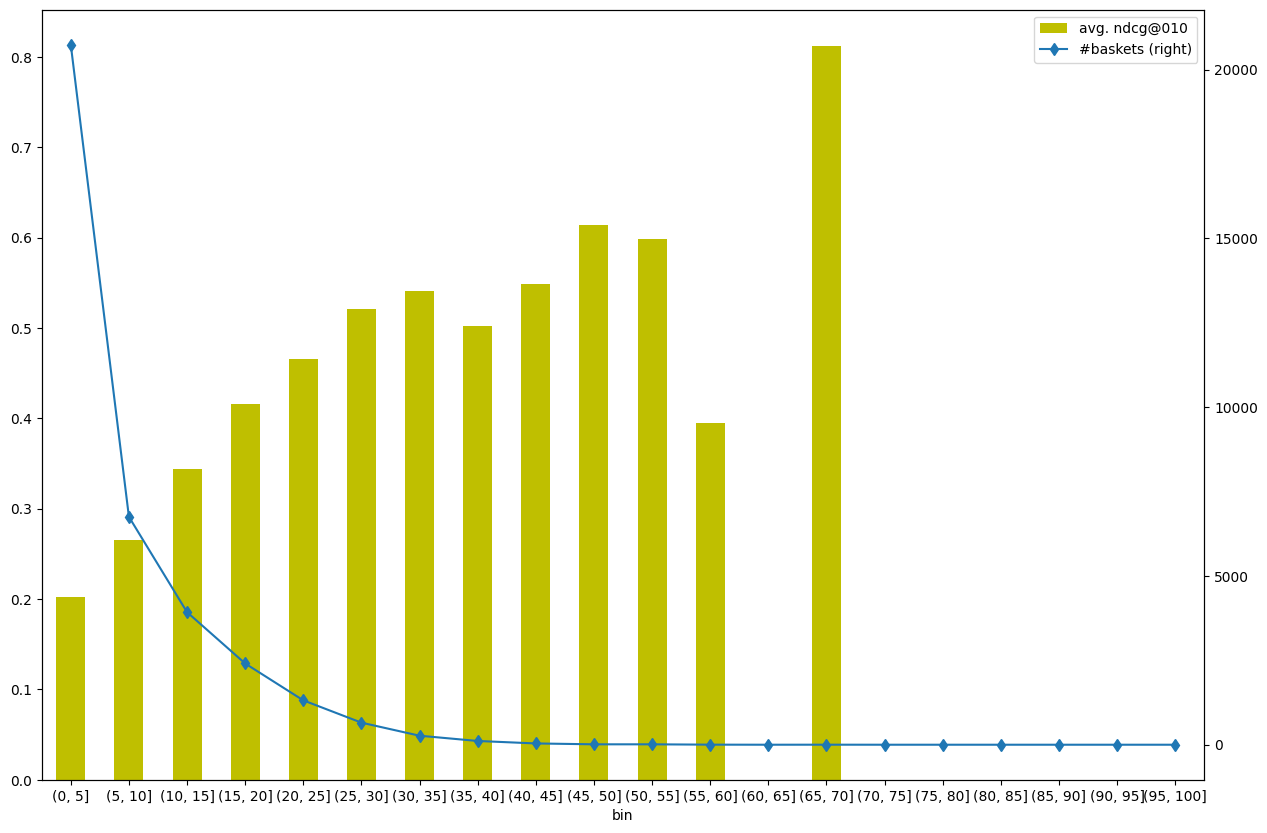

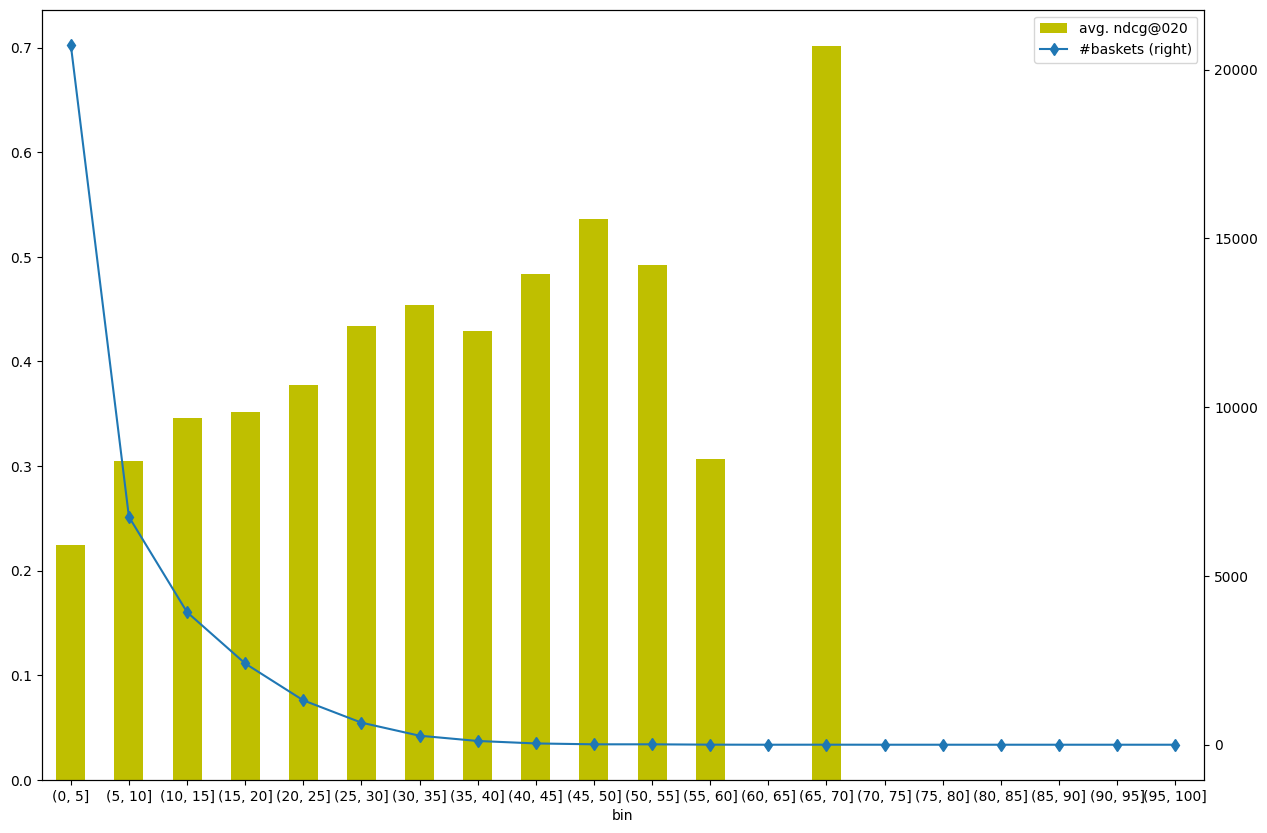

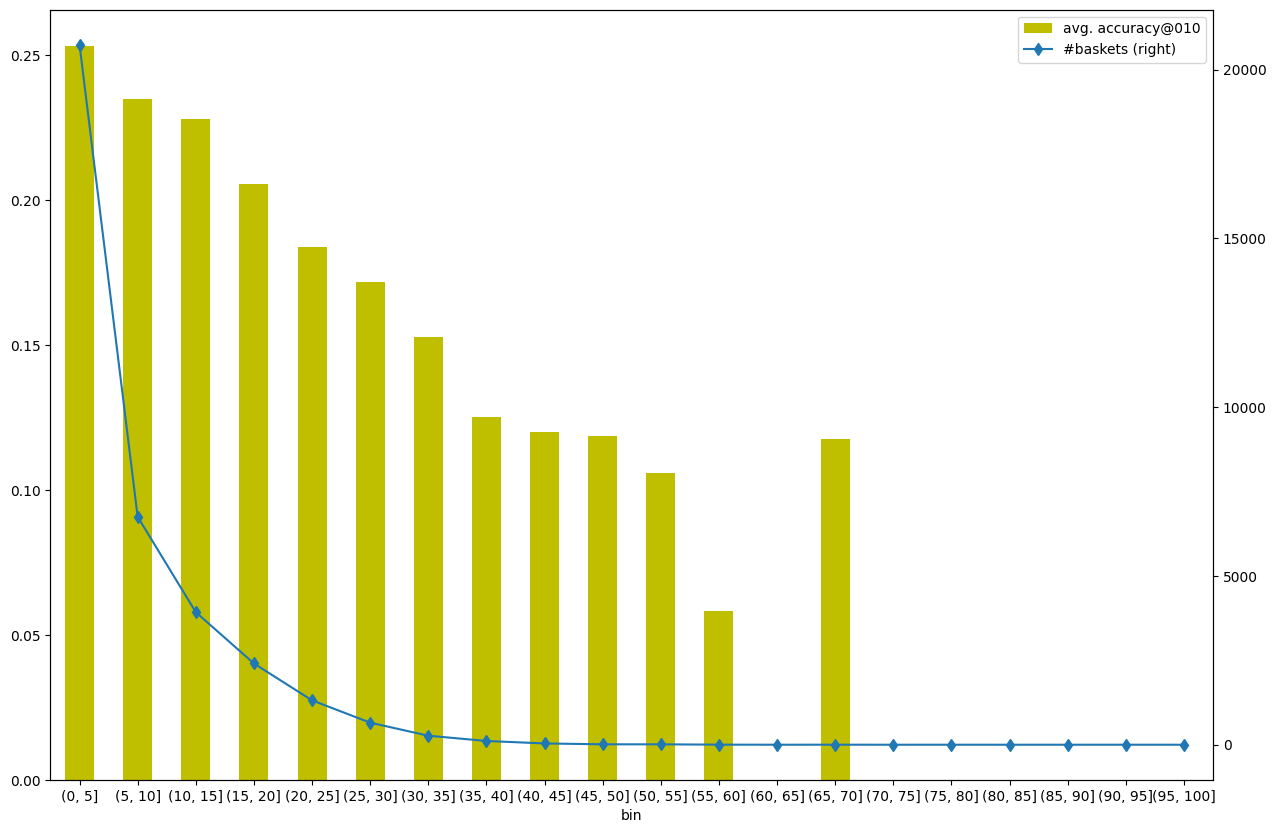

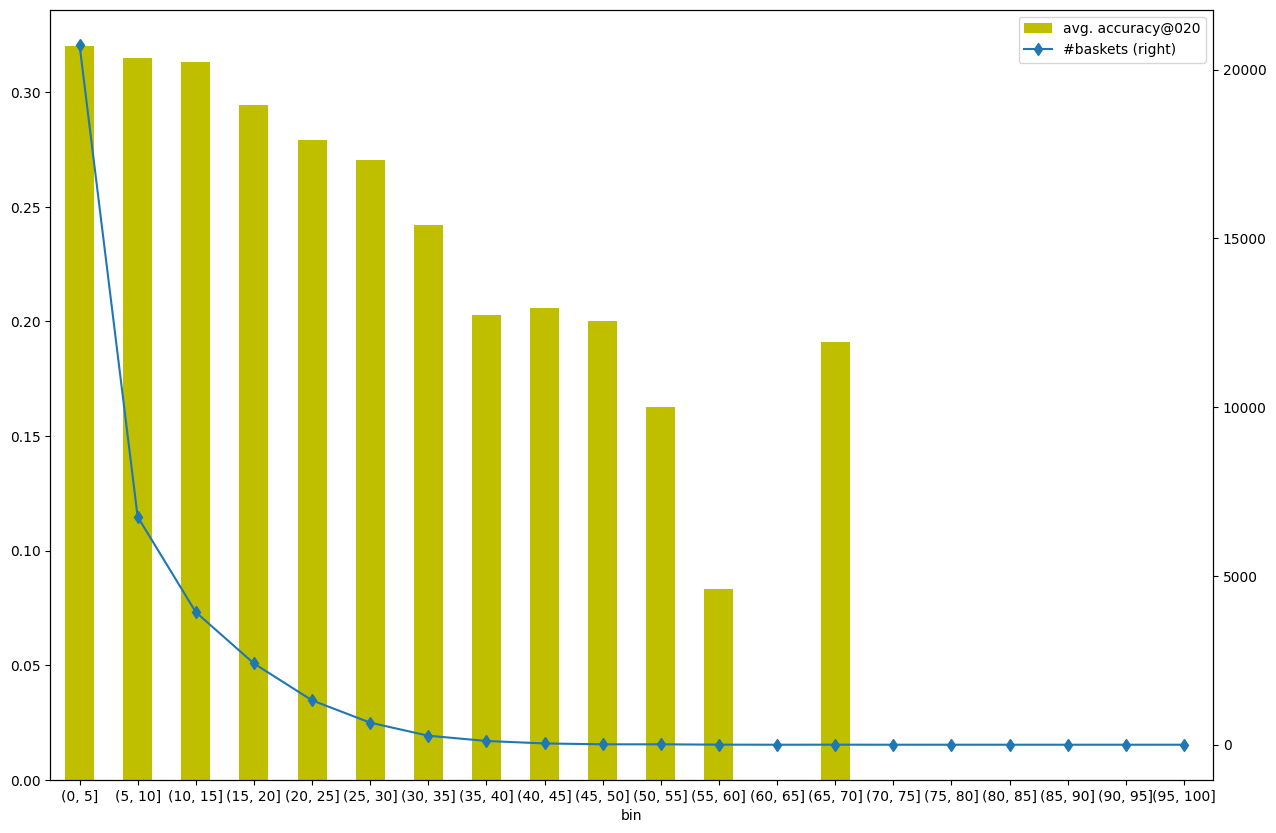

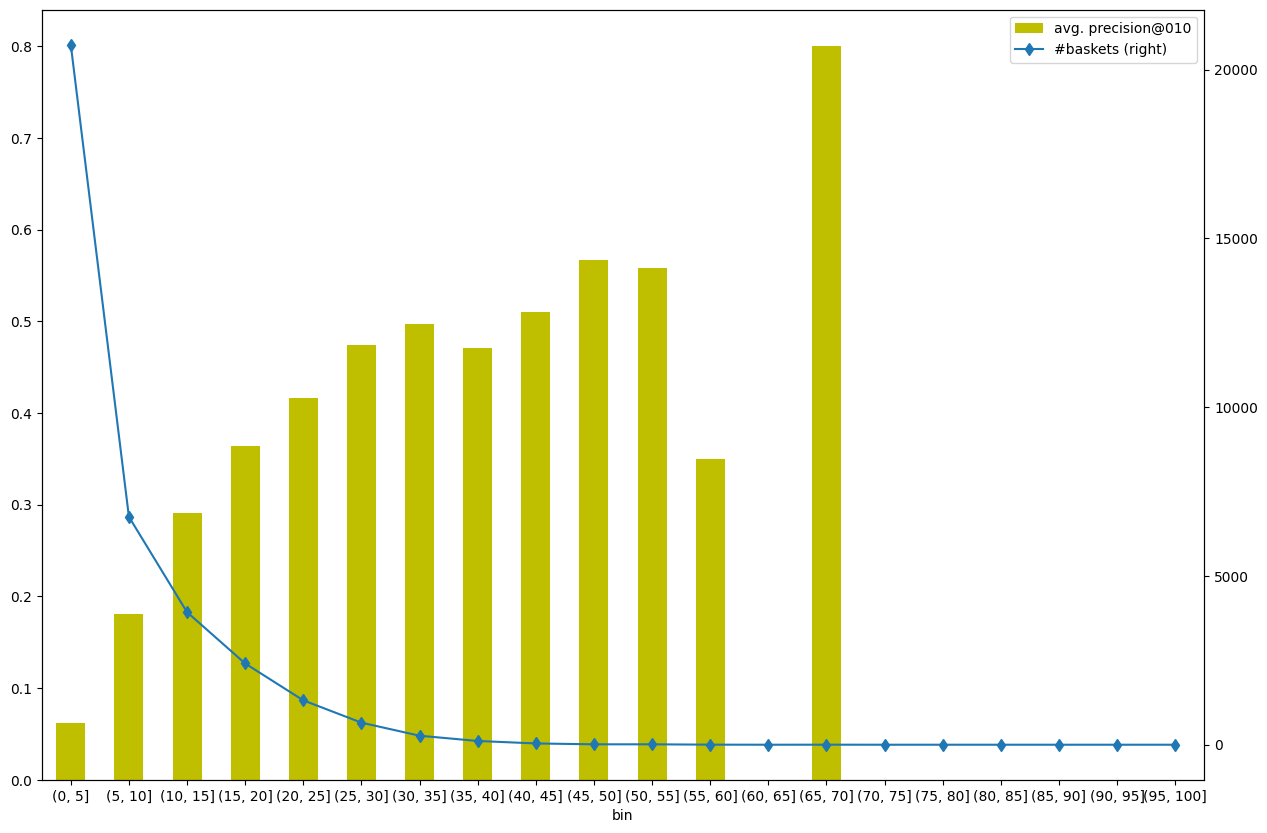

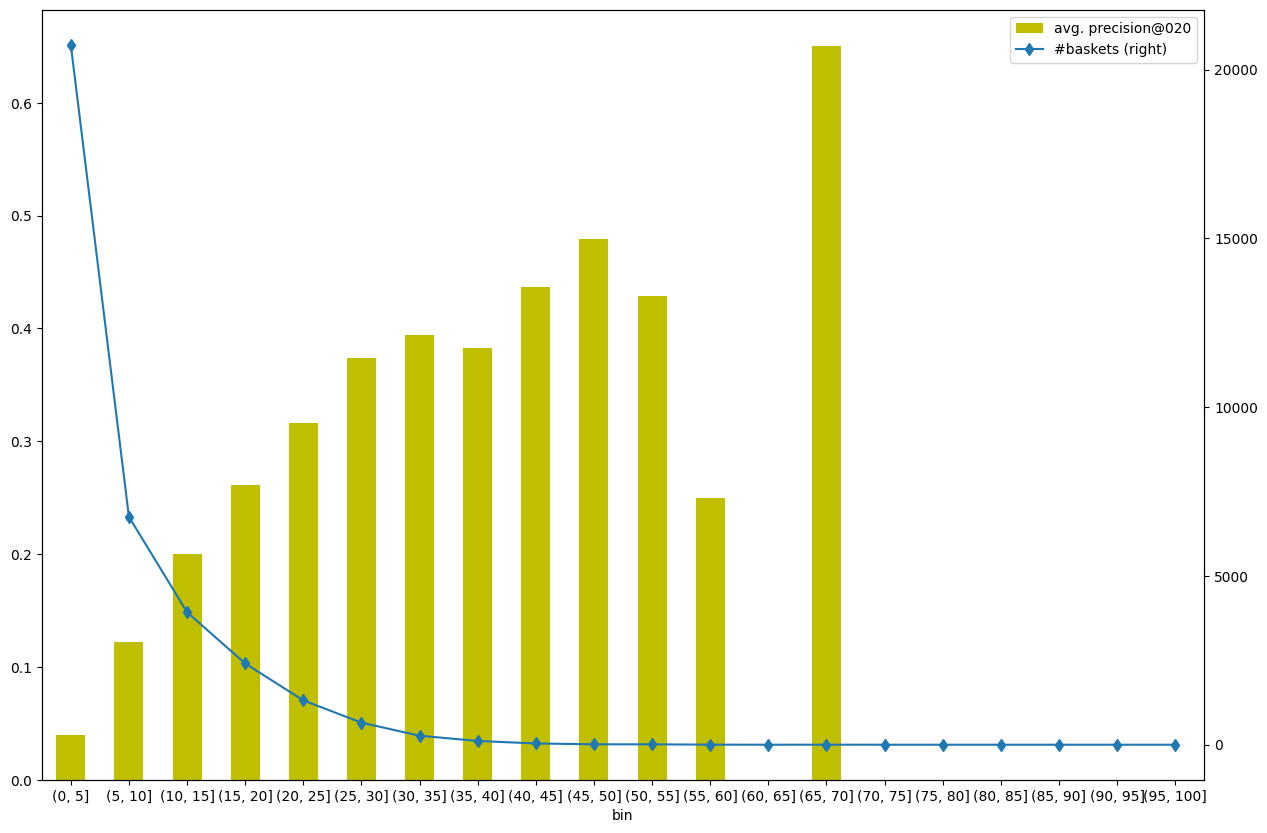

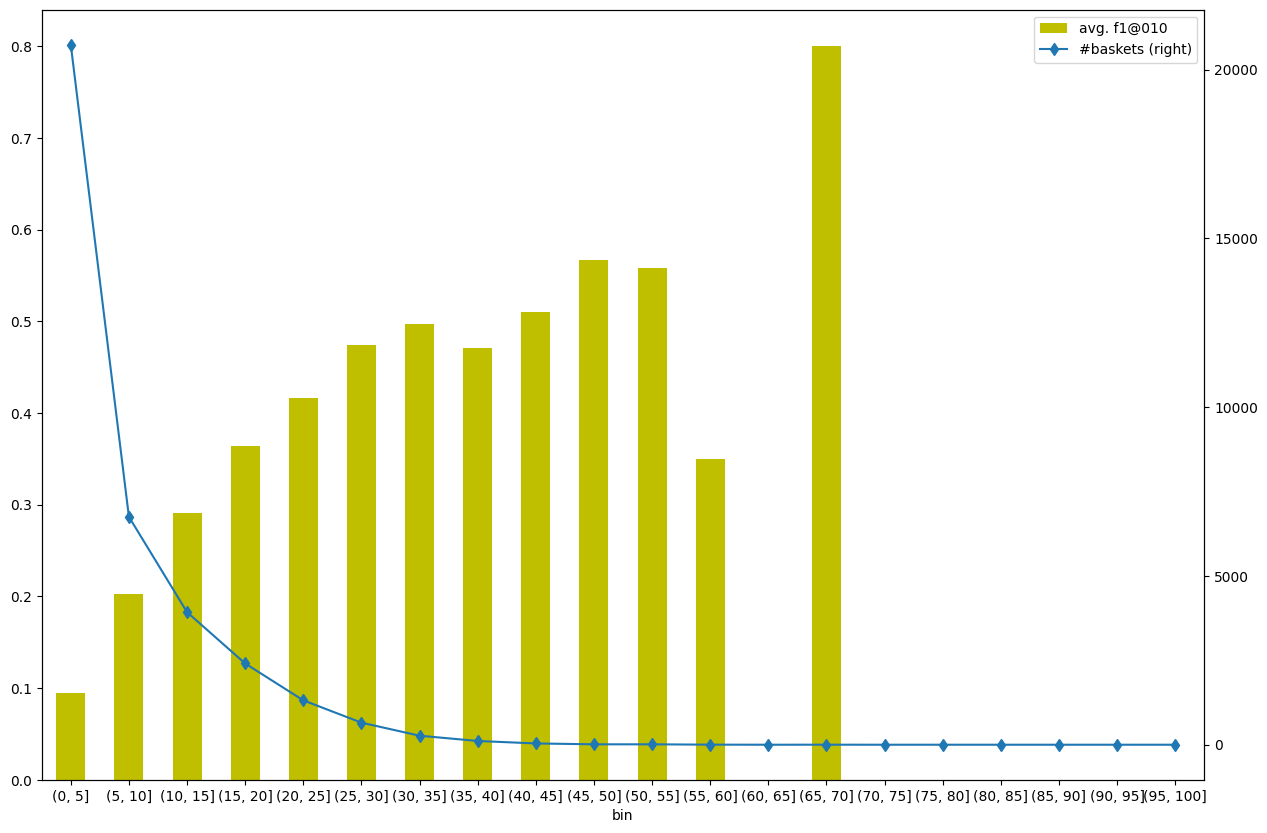

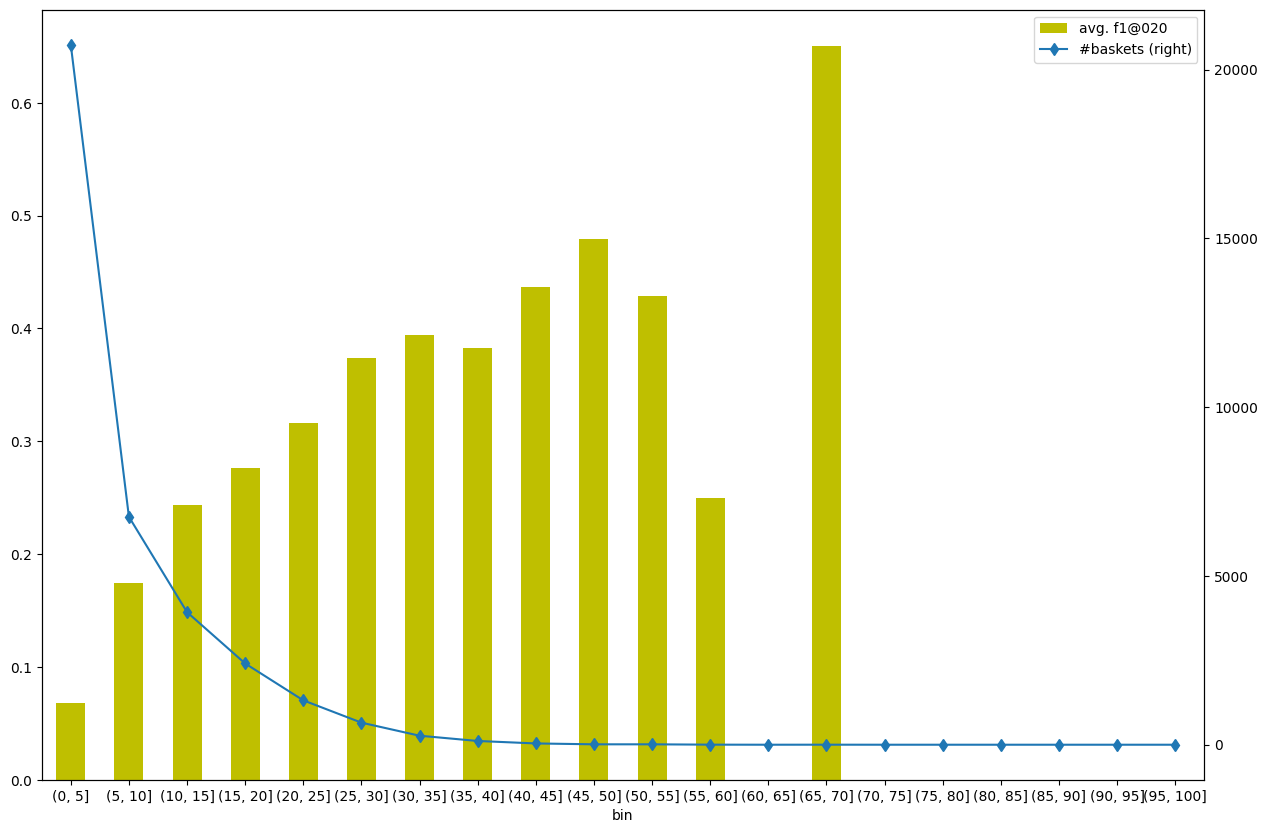

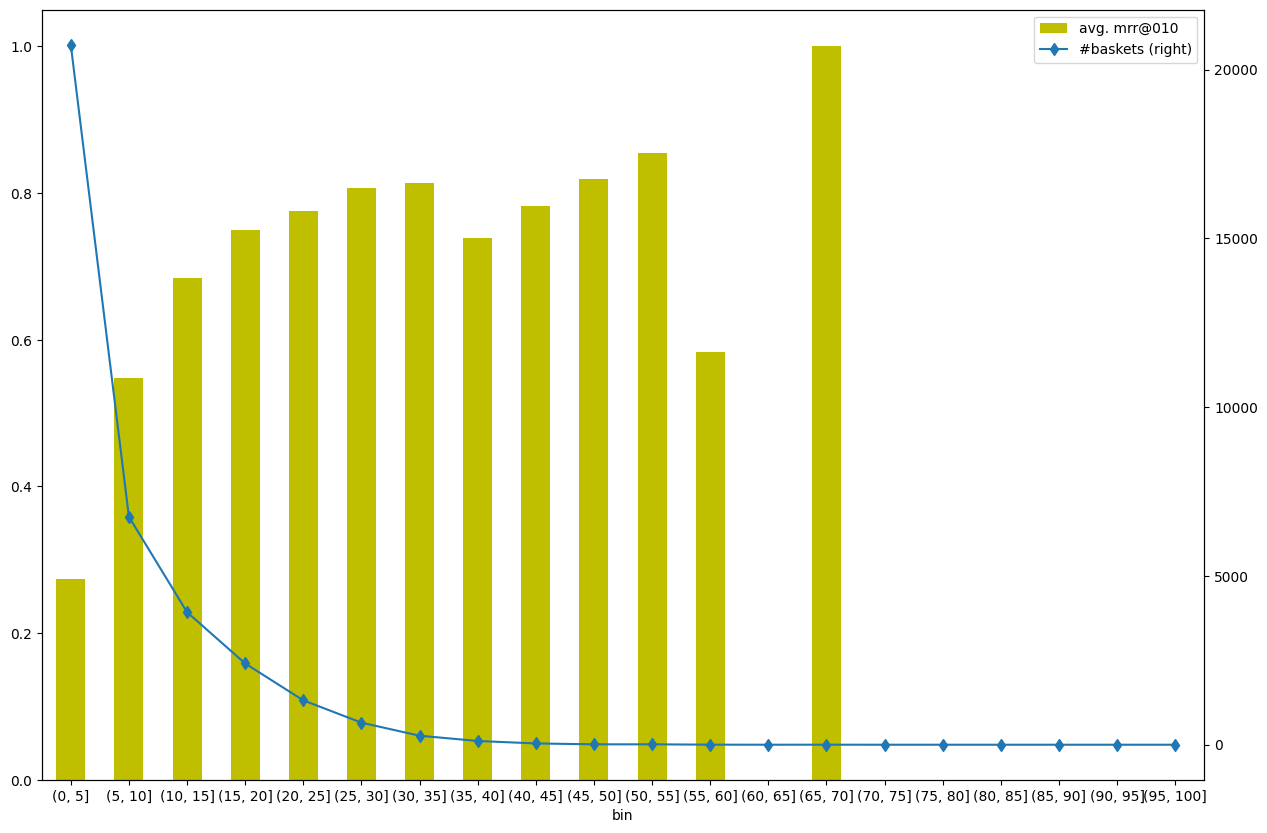

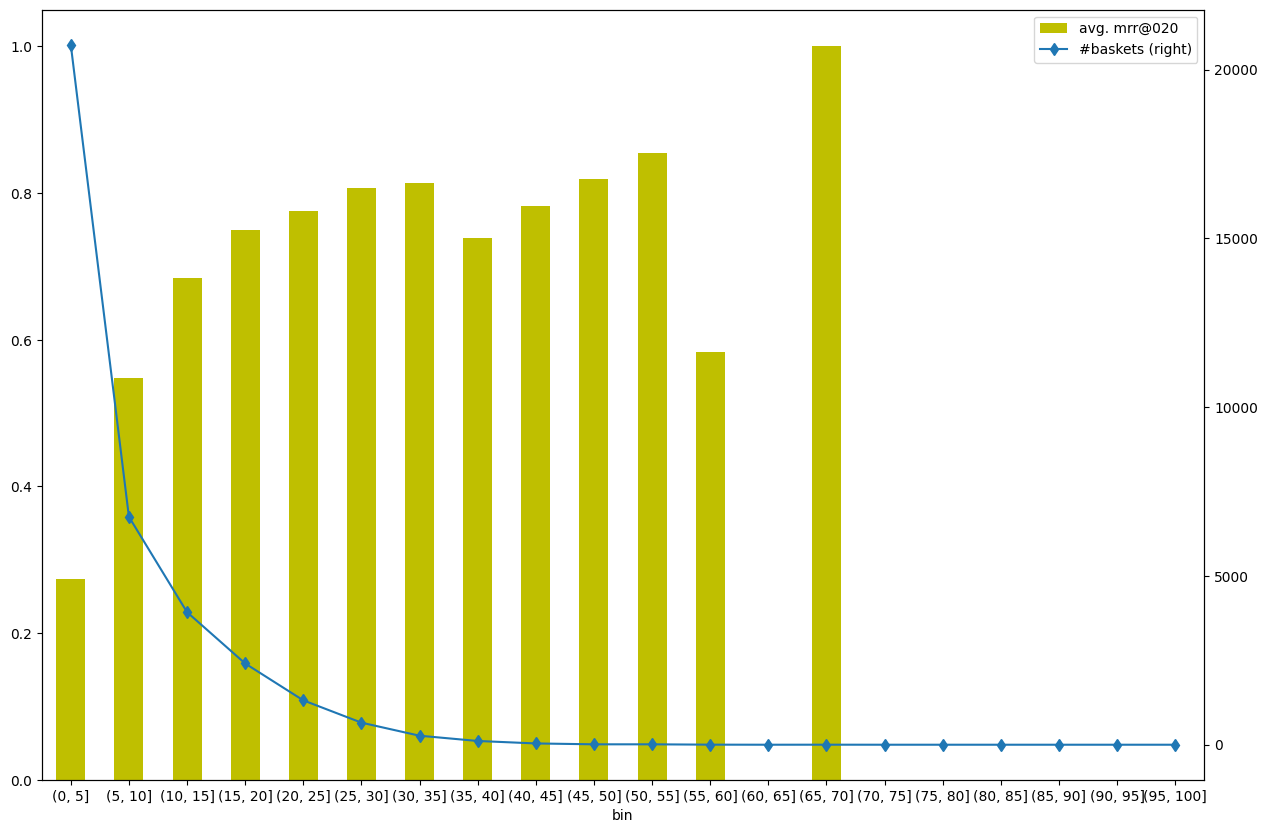

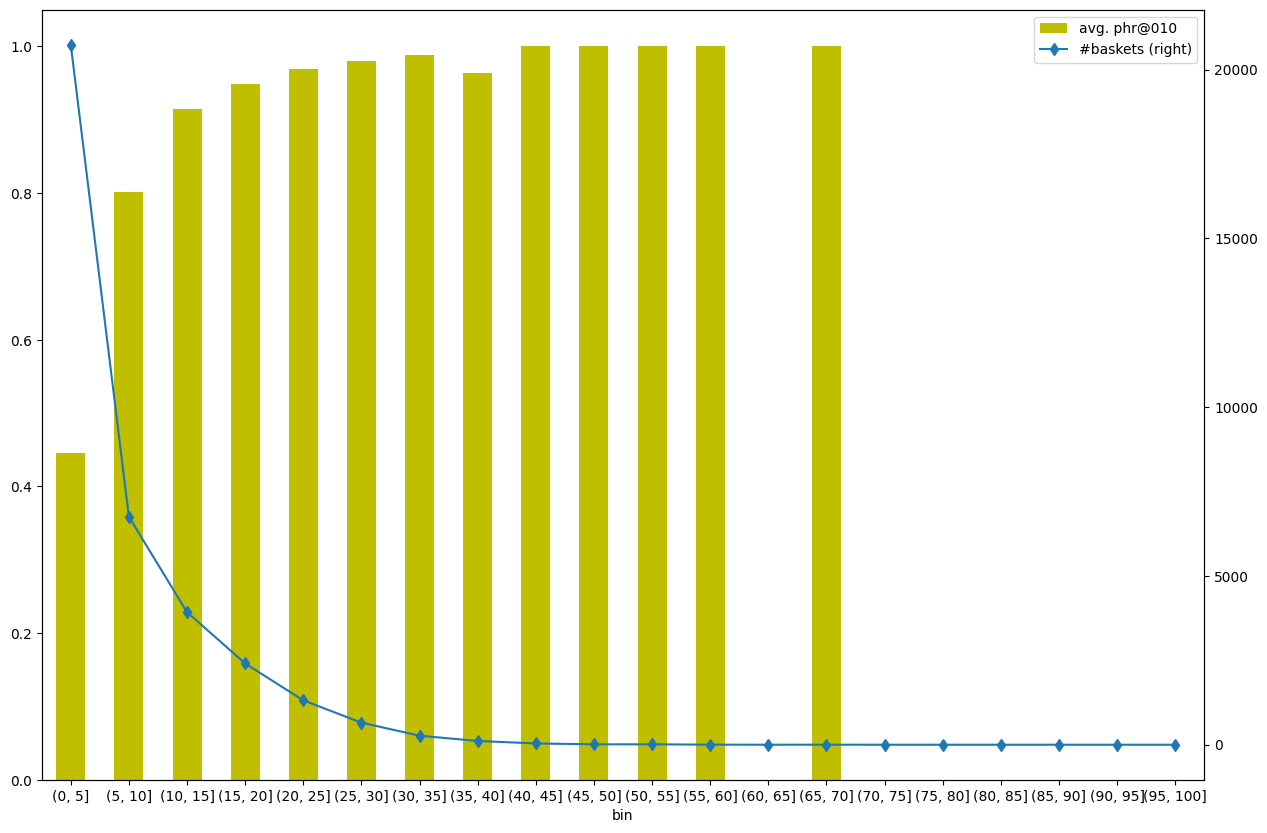

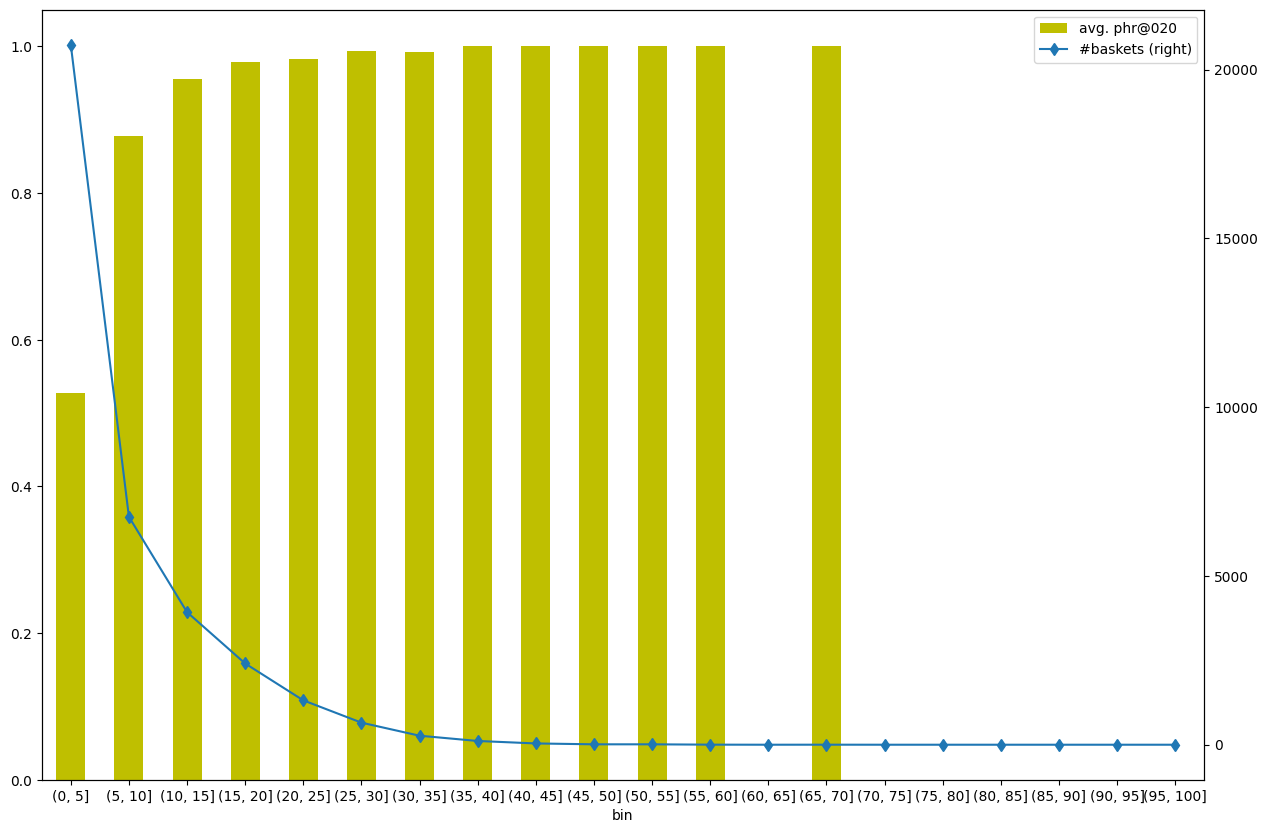

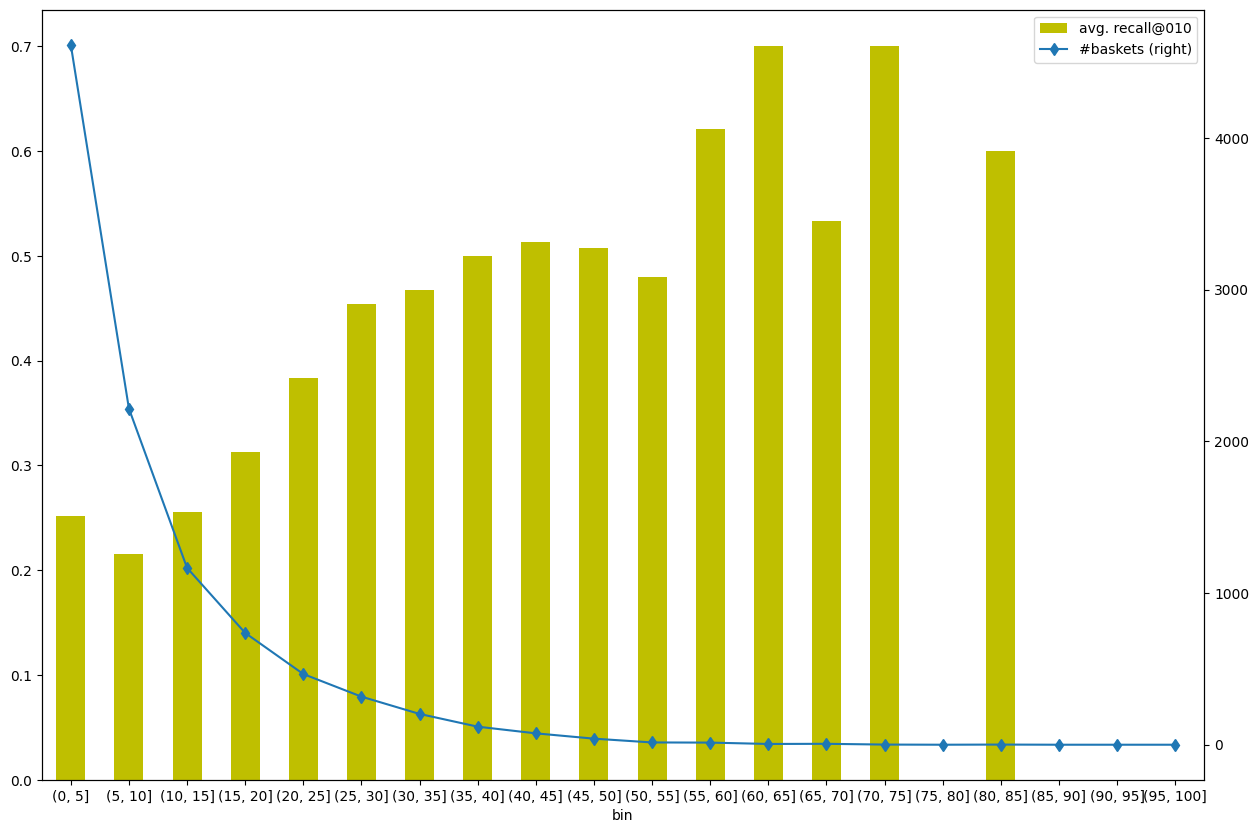

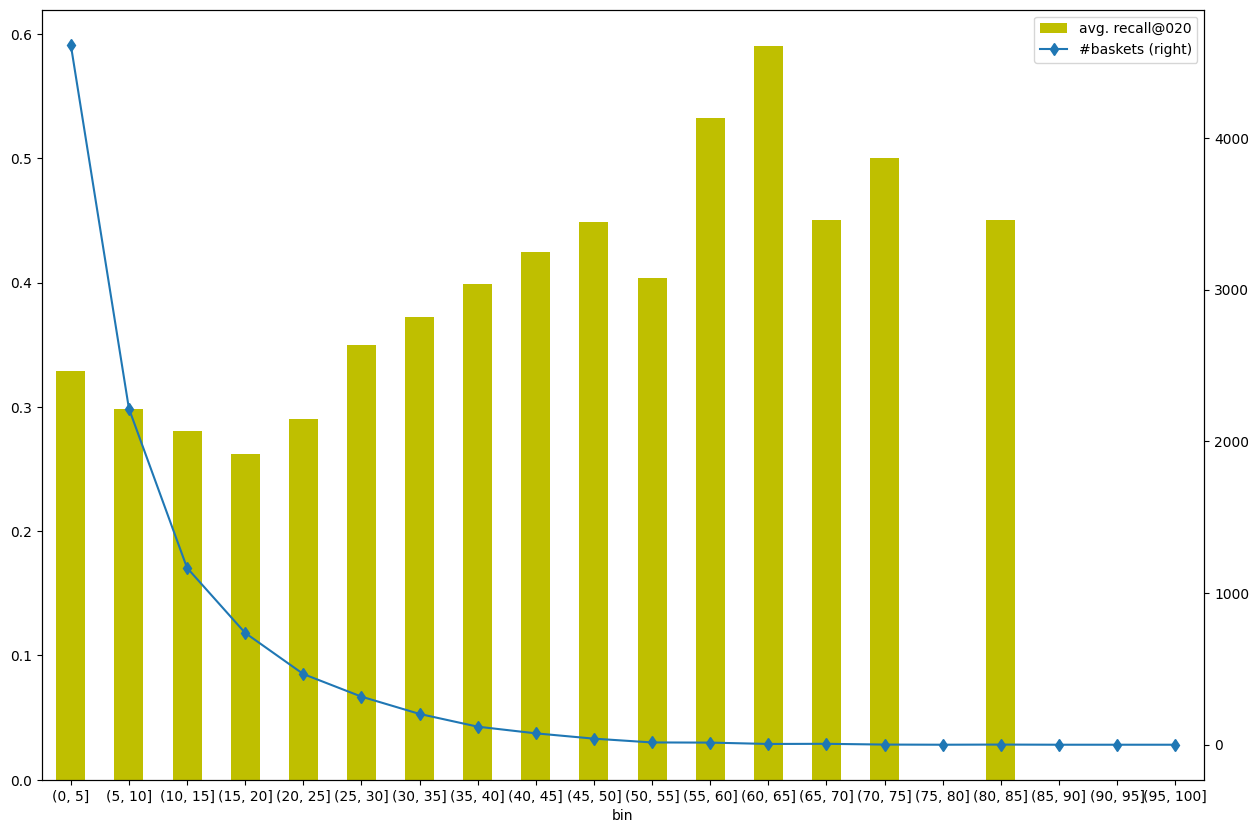

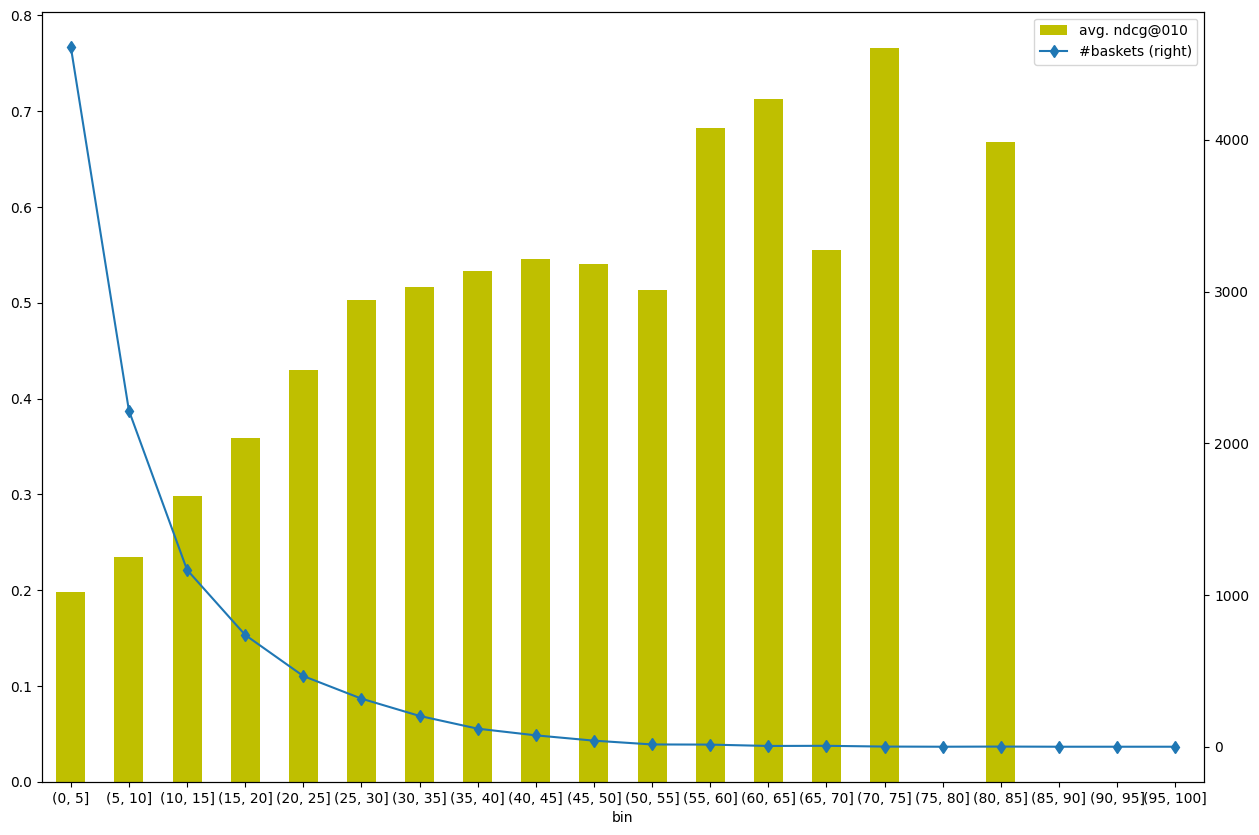

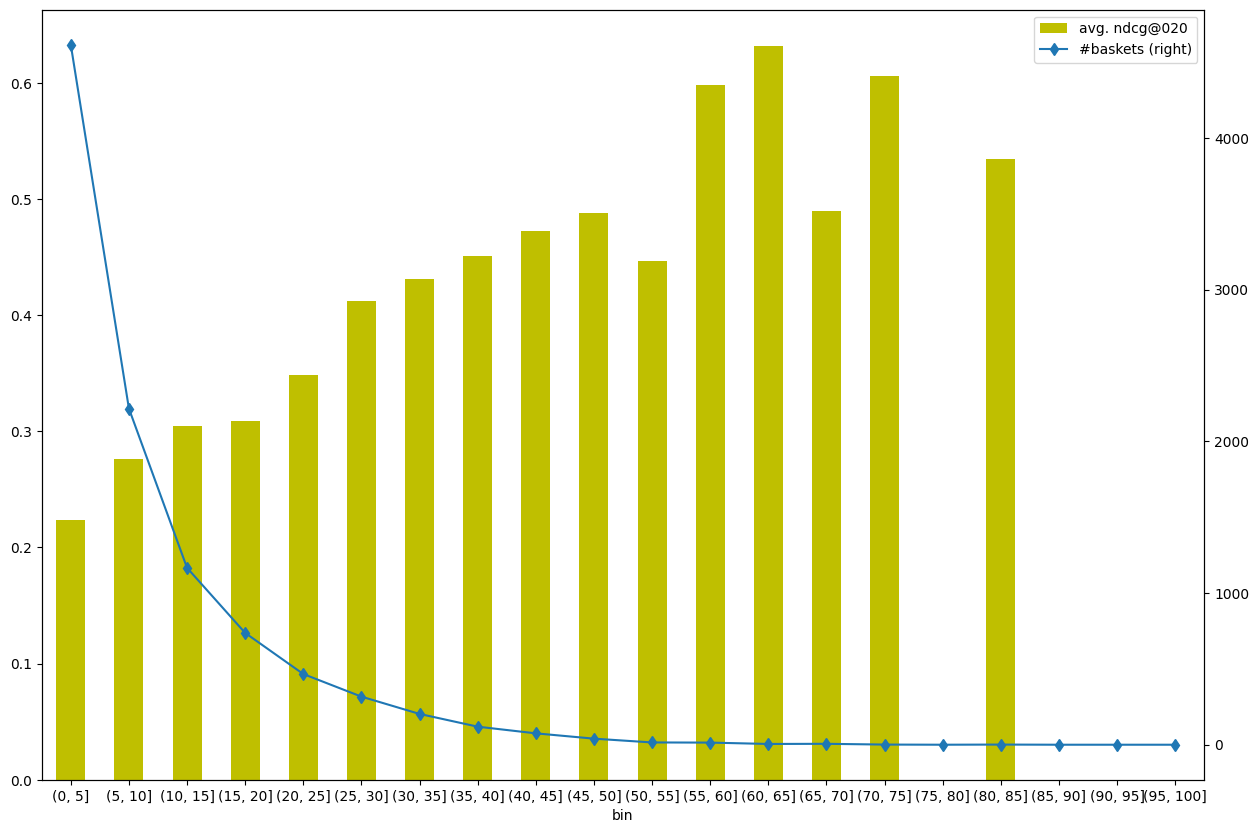

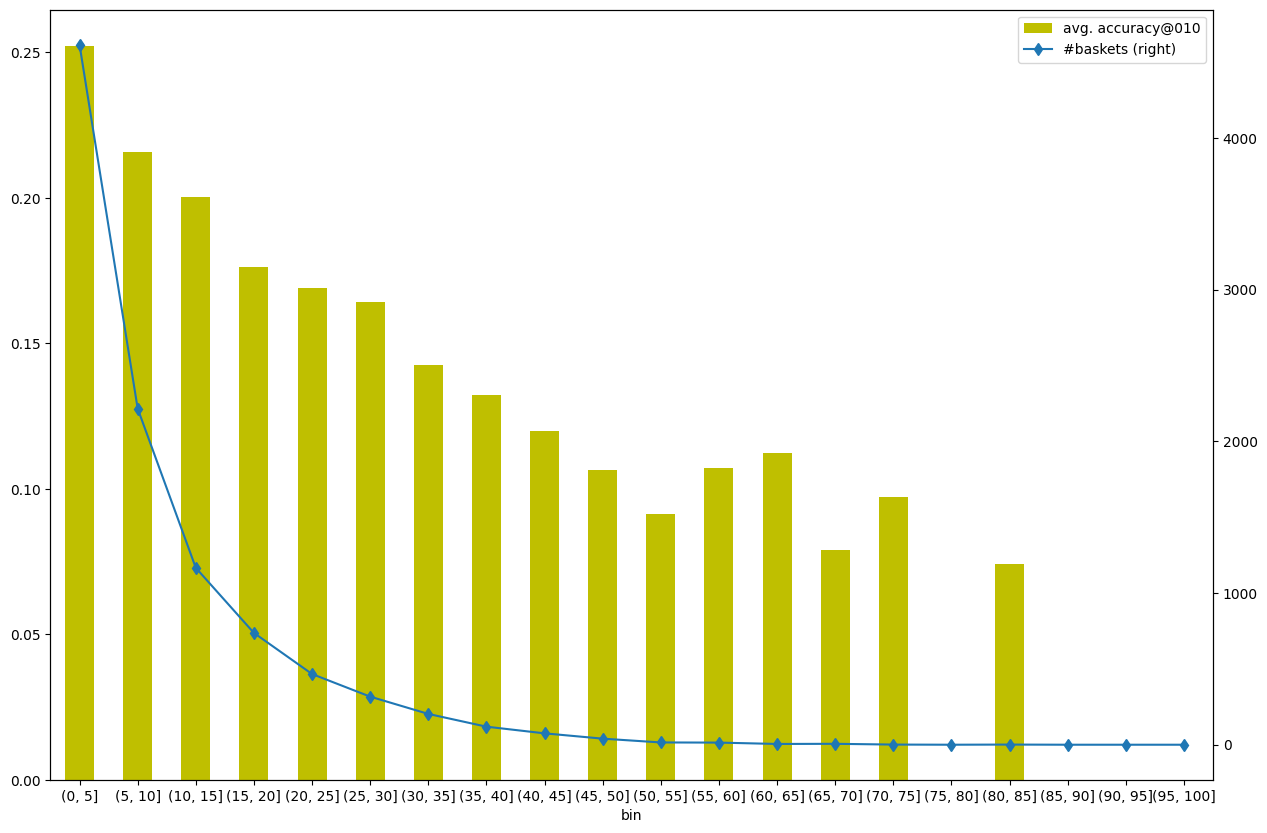

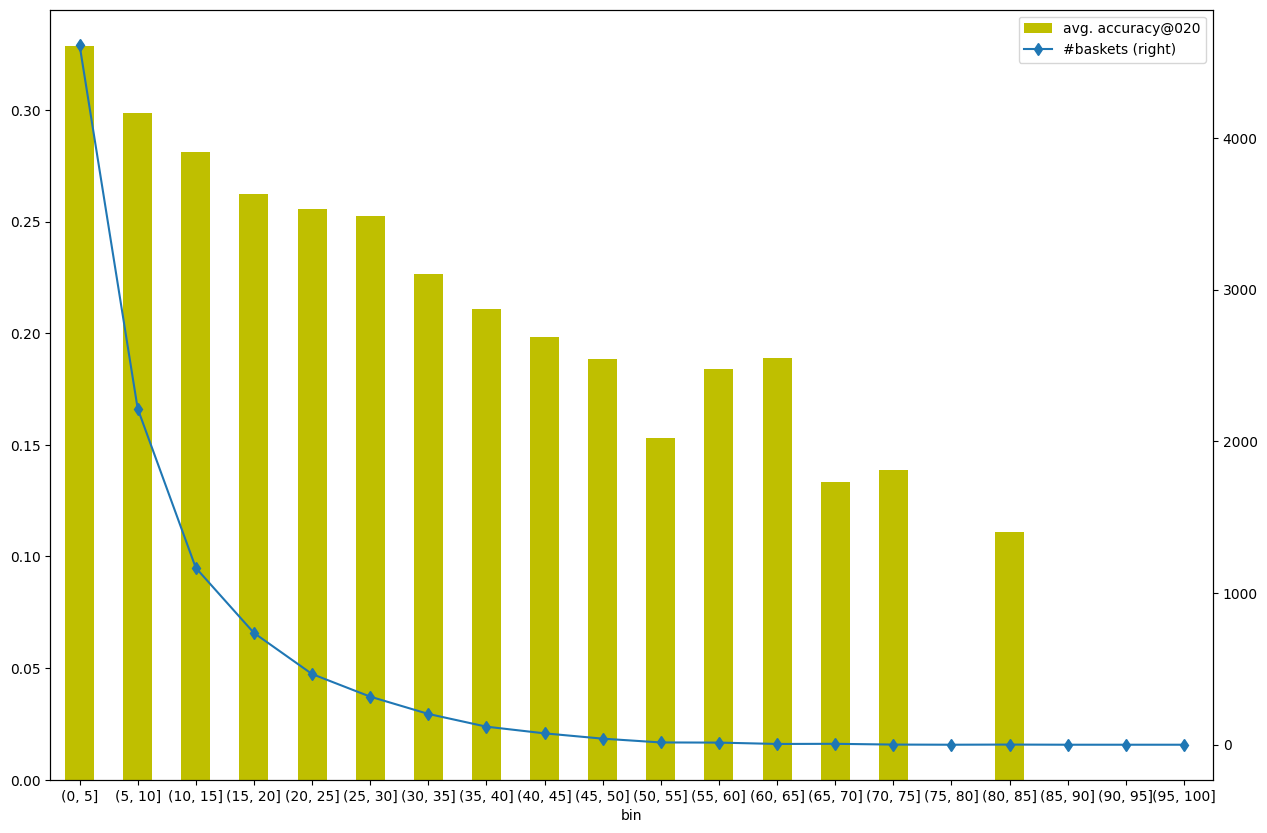

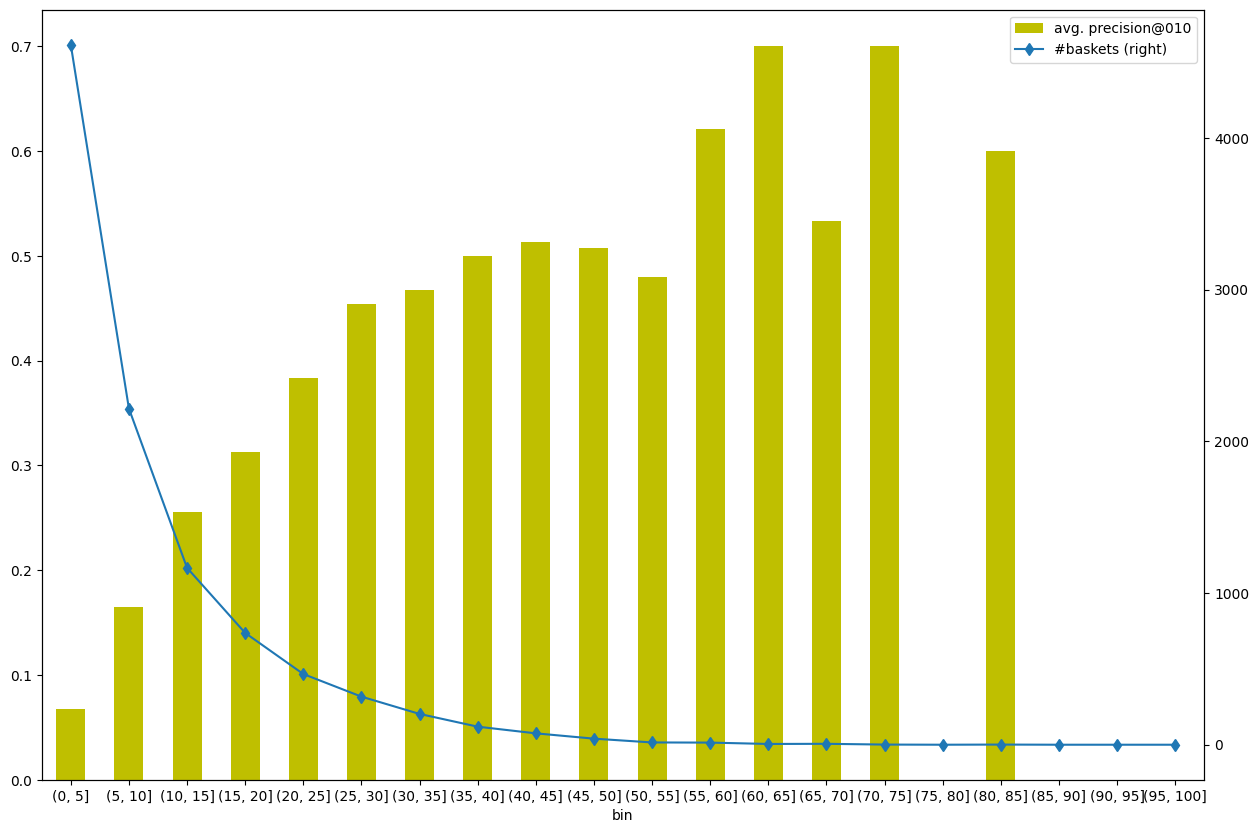

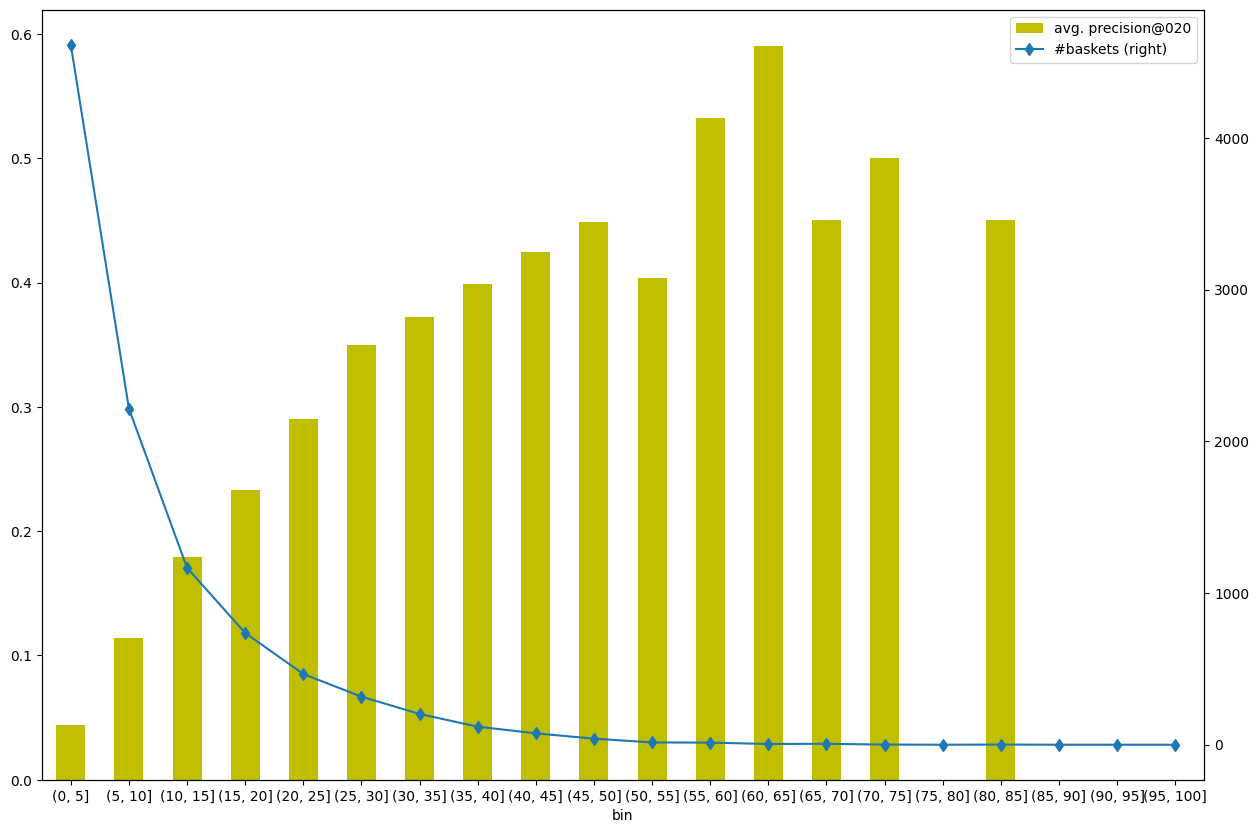

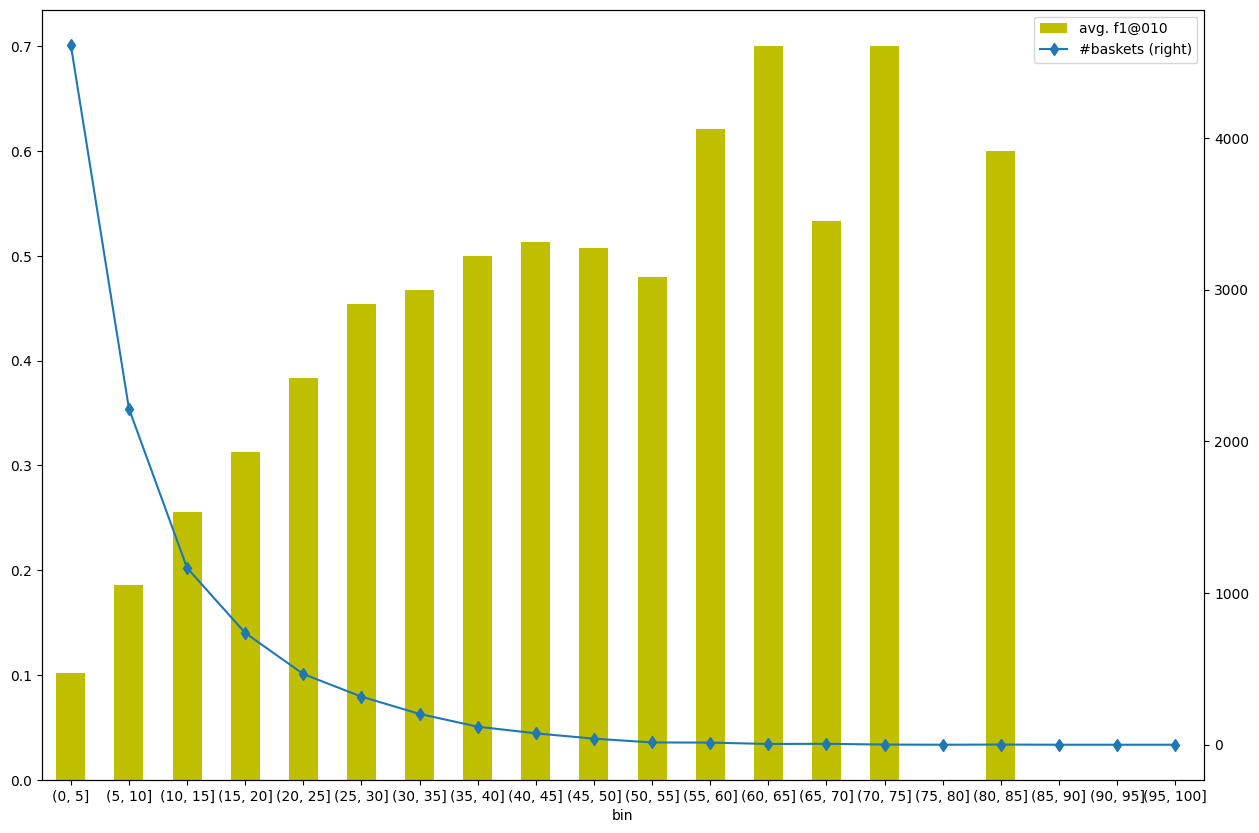

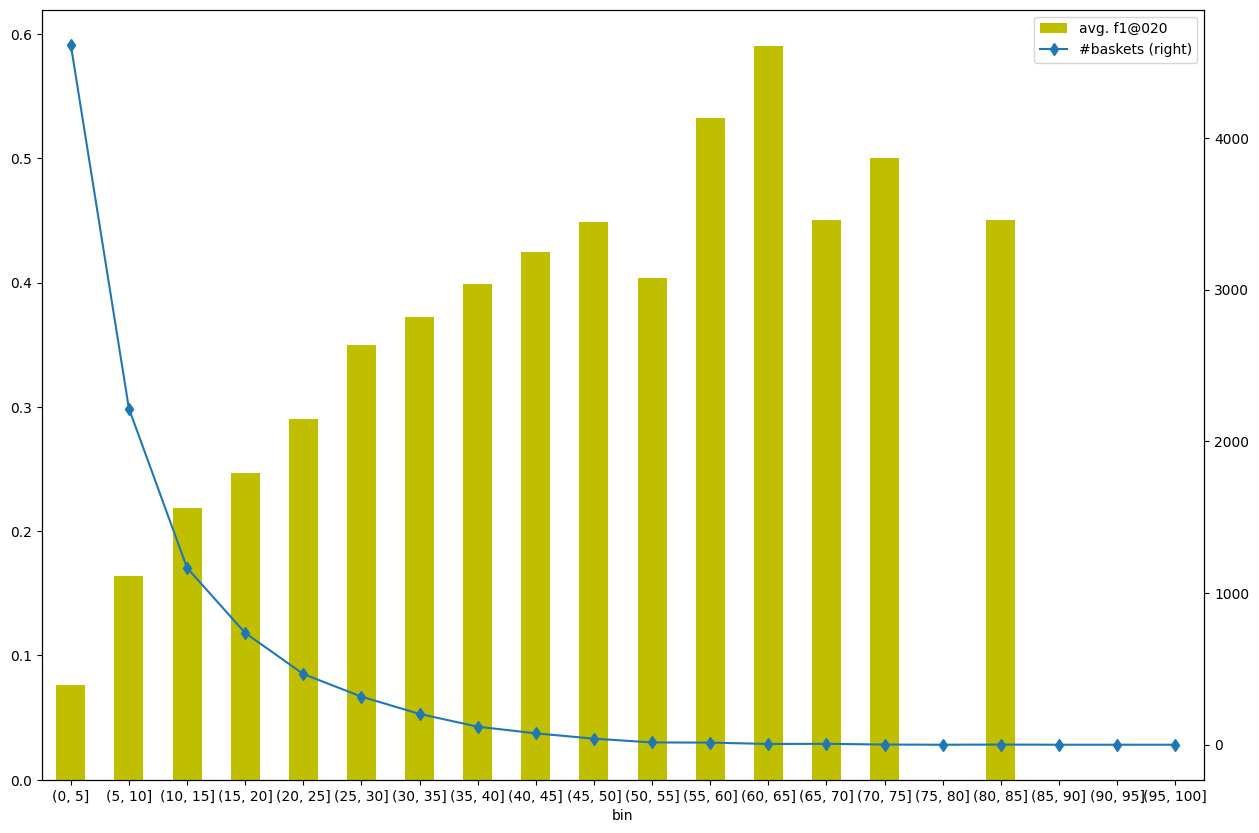

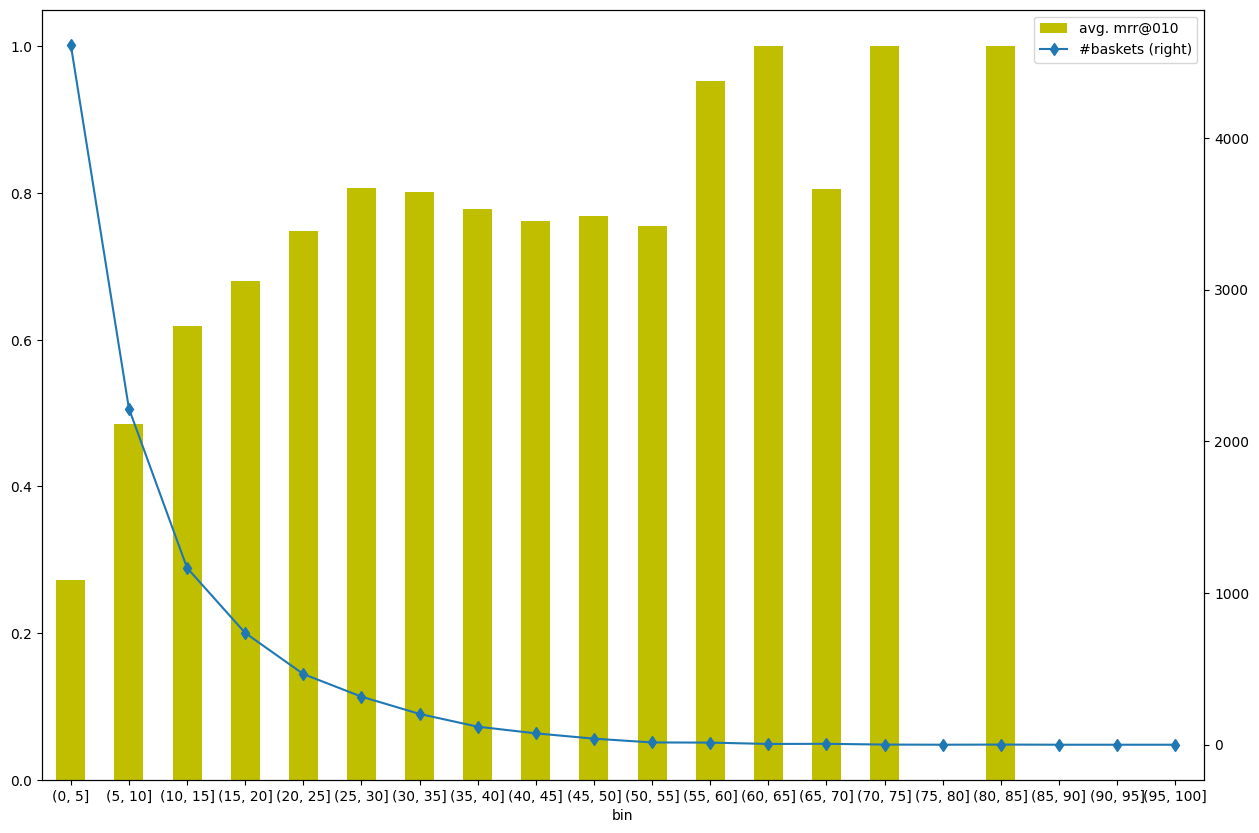

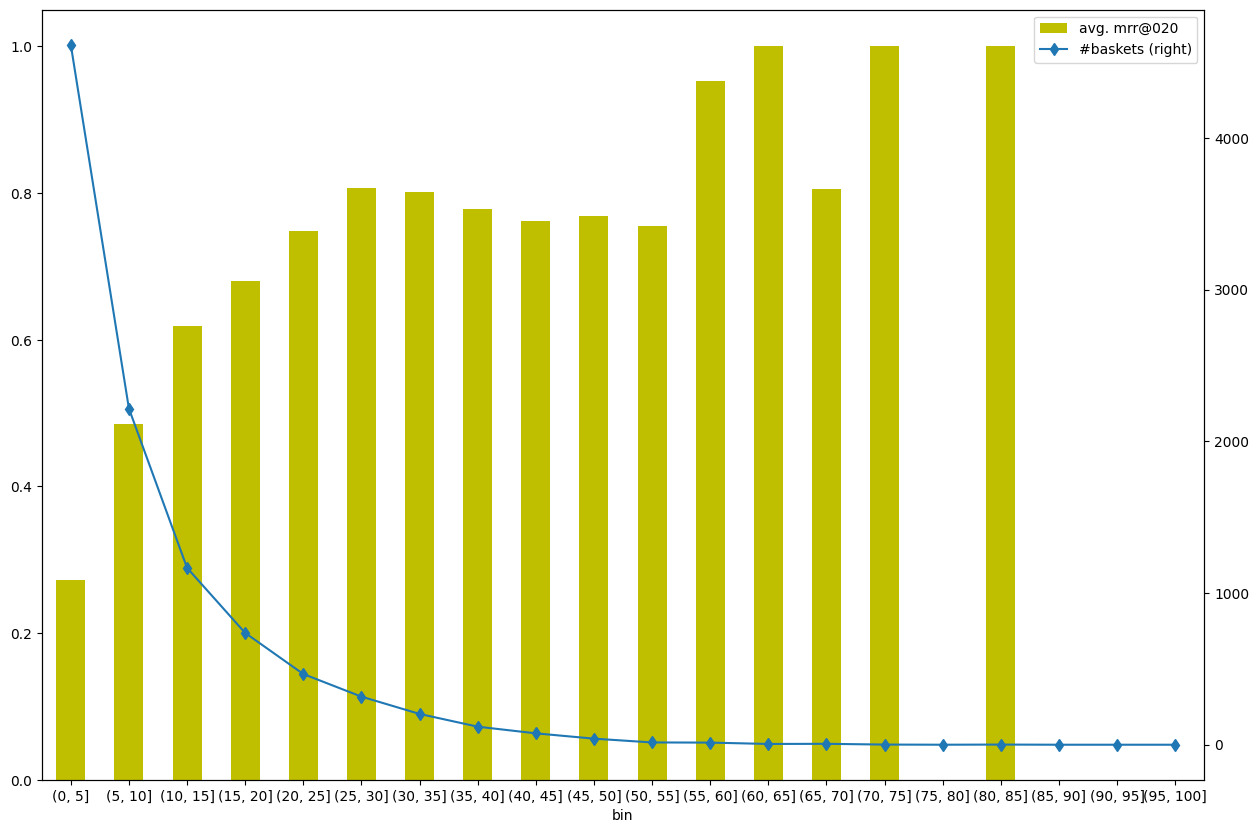

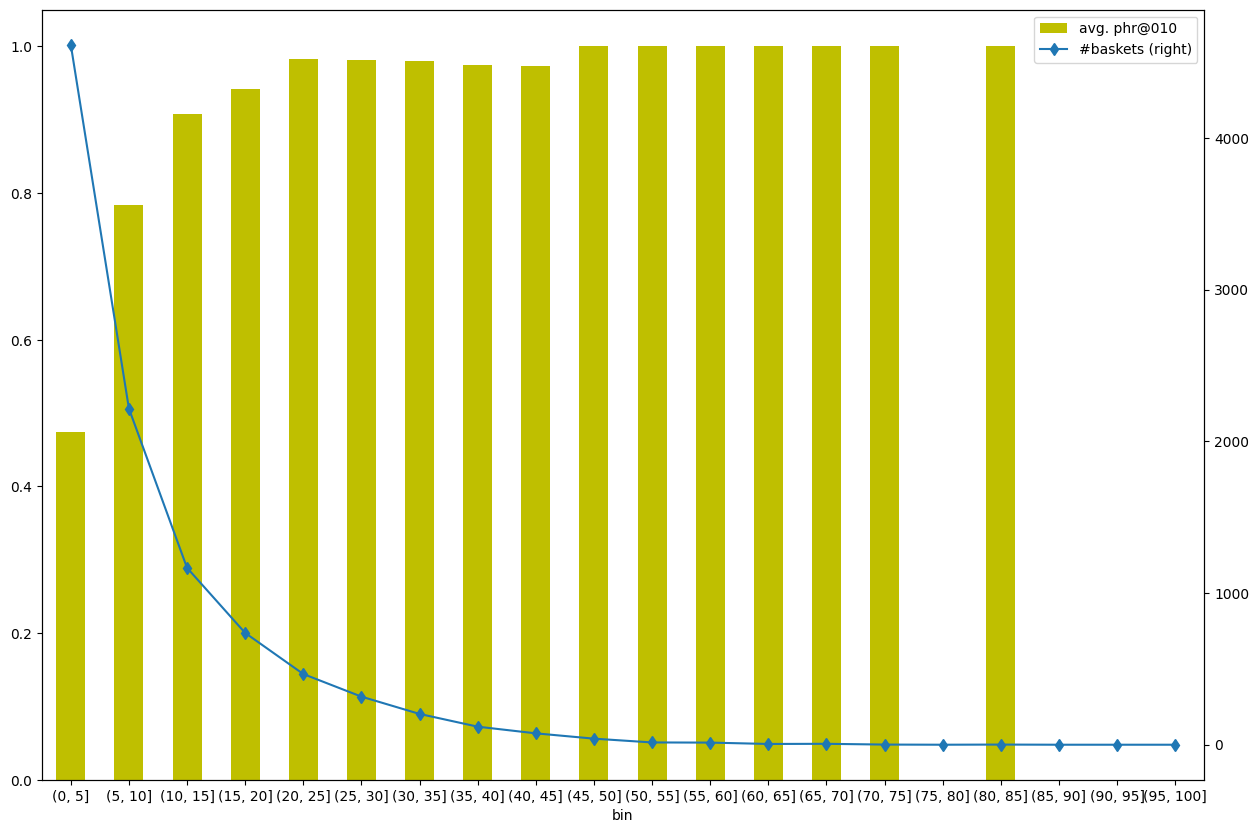

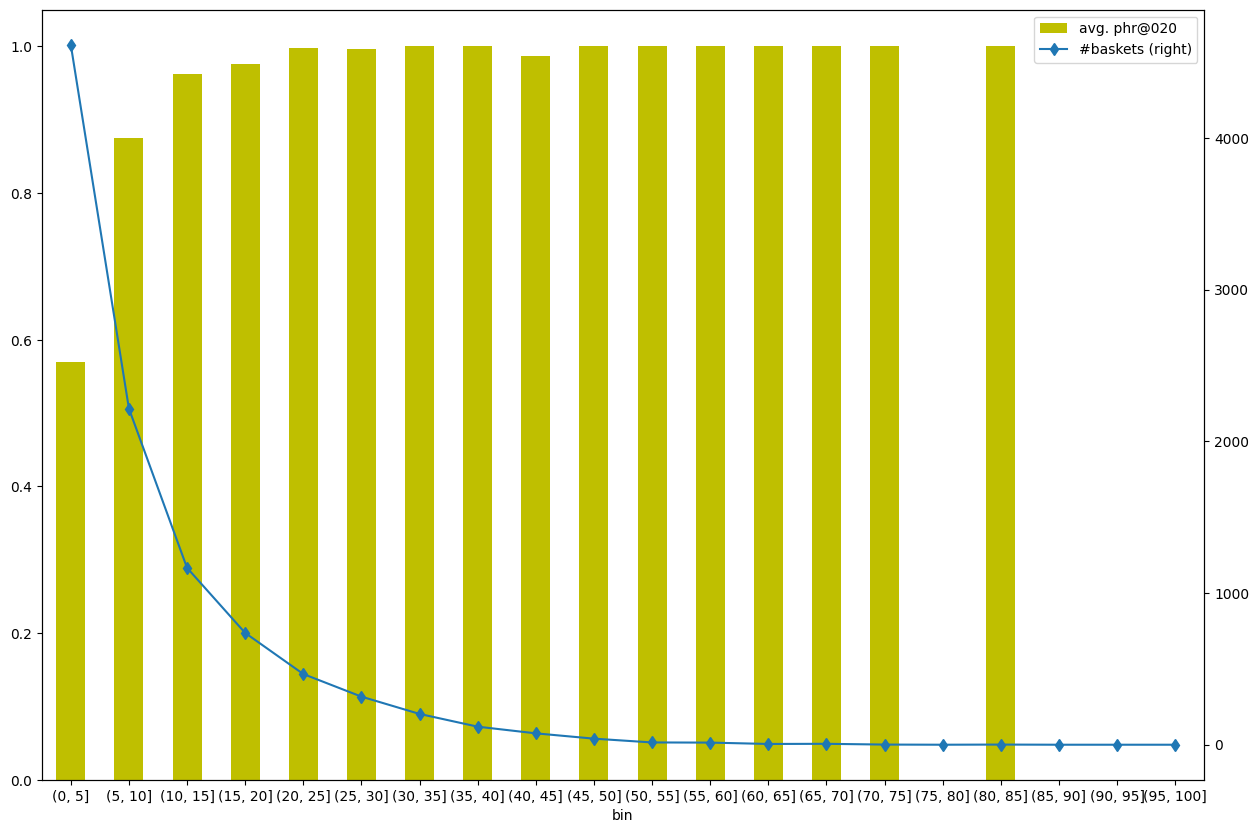

In [416]:
for dataset in datasets:
    path = glob.glob(f'/Users/slawek/PycharmProjects/RecSysProject/results/{dataset}_*_user_metrics.csv')
    df = pd.read_csv(path[0])
    test_df = pd.read_csv(f'/Users/slawek/PycharmProjects/RecSysProject/data/{dataset}/split/test.csv')
    test_df['basket_size'] = test_df.apply(lambda row: len(row['basket'].split(',')), axis=1)
    test_df.drop(columns = ['basket', 'timestamp'], inplace=True)
    df = df.merge(test_df, on=['user_id'])
    df['bin'] = pd.cut(df['basket_size'], list(range(0, 105, 5)))
    metrics = list(df.columns)[:-3]
    for metric in metrics:
        fairness = df.groupby('bin').agg({metric: 'mean', 'user_id': 'count'})
        fig, ax1 = plt.subplots(figsize=(15, 10))
        fairness[metric].plot(kind='bar', color='y', label=f'avg. {metric}')
        leg = plt.legend()
        fairness['user_id'].plot(kind='line', marker='d', secondary_y=True, label='#baskets')
        leg2 = plt.legend()
        plt.legend(leg.get_patches()+leg2.get_lines(), [text.get_text() for text in leg.get_texts()+leg2.get_texts()],
                   loc='upper right')
        leg.remove()
        plt.savefig(f'/Users/slawek/PycharmProjects/RecSysProject/report_results/fairness/{dataset}_{metric}.png')